In [1]:
from json import load
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.ndimage import label

from collections import deque

DIRPATH = './maps/example_maps_odom_v7_005_waffle_counter_clockwise'
MAP_001 = 'map_20250330_222348_568341.json'

VAL_UNKNOWN = -1
VAL_FREE = 0
VAL_OCCUPIED = 100
VAL_INACCESSIBLE = 101

VAL_CURR_POSITION = 200
VAL_NEXT_GOAL = 201

VAL_ESTIMATED_WALL = 250

colormap = {
    VAL_UNKNOWN: [0.5, 0.5, 0.5],  # Gray (unknown terrain)
    VAL_FREE: [1.0, 1.0, 1.0],  # White (blank space)
    VAL_OCCUPIED: [0.0, 0.0, 0.0],  # Black (walls)
    VAL_INACCESSIBLE: [0.0, 1.0, 0.0],  # Green (estimated walls)
    
    VAL_CURR_POSITION: [1.0, 0.0, 0.0],  # Red (current position)
    VAL_NEXT_GOAL: [0.0, 0.0, 1.0],  # Blue (next goal)
    VAL_ESTIMATED_WALL: [1.0, 0.5, 0.0],  # Orange (estimated walls)
}

RESOLUTION = 0.05  # meters per pixel


## Input and output

In [2]:
def read_data_map(_dir_path: str=DIRPATH, _map_path: str=MAP_001) -> tuple[np.ndarray[tuple[()], np.dtype], float, float]:
    """Reads map data from a JSON file and returns the grid, origin x, and origin y.
    Args:
        _dir_path (str, optional): Directory path to the map file. Defaults to DIRPATH.
        _map_path (str, optional): Map file name. Defaults to MAP_001.

    Returns:
        _type_: _description_
    """
    
    _data = dict()
    with open(_dir_path + '/' + _map_path, 'r+') as json_data:
        _data = load(json_data)
        json_data.close()
    
    try:
        _data = _data['map']
        print(_data)

        width = _data['info']['width']
        height = _data['info']['height']
        origin_x = _data['info']['origin']['position']['x']
        origin_y = _data['info']['origin']['position']['y']
        _data = _data['data']

        grid = np.array(_data).reshape((height, width))

        return grid, origin_x, origin_y

    except:
        print('No data found in the map file')
    
    return None, None, None

def read_data_odom(_dir_path: str=DIRPATH, _odom_path: str=MAP_001) -> tuple[int, int]:
    _data = dict()
    with open(_dir_path + '/' + _odom_path, 'r+') as json_data:
        _data = load(json_data)
        json_data.close()
    
    try:
        _data = _data['odom']
        print(_data)

        x = _data['pose']['pose']['position']['x']
        y = _data['pose']['pose']['position']['y']

        return x, y

    except:
        print('No data found in the odom file')
    
    return None, None
    

def print_plot_v2(
    grid: np.ndarray[tuple[()], np.dtype],
    title: str="Original map",
    filename: str="Not provided",
    occupied: int=-1,
    free: int=-1,
    inaccessible: int=-1,
    unknown: int=-1,
    explored_percent: float=-1.0,
    position_x: float=-1,
    position_y: float=-1) -> None:
    height, width = grid.shape
    colored_map = np.zeros((height, width, 3))

    for y in range(height):
        for x in range(width):
            color_code = grid[y, x]
            colored_map[y, x] = colormap[color_code]
            
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(colored_map, origin='upper')
    plt.title(title)
    plt.axis('off')
    
    legend_text = (f"Filename: {filename}\n"
                   f"Occupied: {occupied}\n"
                   f"Free: {free}\n"
                   f"Inaccessible: {inaccessible}\n"
                   f"Unknown: {unknown}\n"
                   f"Explored: {100*explored_percent:.8f}\n"
                   f"Position: {position_x:.4f}, {position_y:.4f}"
                   )
    
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.text(0.1, 0.5, legend_text, fontsize=12, verticalalignment='center')
    
    plt.show()
    
    return

## Space estimation

In [3]:
def get_reachable_mask(grid: np.ndarray, position: tuple[int, int]) -> np.ndarray[tuple[()], np.dtype]:
    h, w = grid.shape
    visited = np.zeros_like(grid, dtype=bool)
    q = deque([position])
    visited[position[1], position[0]] = True
    
    while q:
        x, y = q.popleft()
        for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < w and 0 <= ny < h:
                if not visited[ny, nx] and grid[ny, nx] in [0, -1]:
                    visited[ny, nx] = True
                    q.append((nx, ny))

    return visited


In [4]:
def fill_outside_with_val_inaccessible(grid: np.ndarray, position: tuple[int, int]) -> np.ndarray[tuple[()], np.dtype]:
    reachable = get_reachable_mask(grid, position)
    grid[(grid == -1) & (~reachable)] = VAL_INACCESSIBLE
    
    return grid

def is_fully_enclosed(grid: np.ndarray, position: tuple[int, int]) -> bool:
    reachable = get_reachable_mask(grid, position)
    unknown_mask = (grid == -1)
    
    return not np.any(reachable & unknown_mask)

def fill_enclosed_unknowns_v2(grid: np.ndarray, position: tuple[int, int]) -> np.ndarray[tuple[()], np.dtype]:
    reachable = get_reachable_mask(grid, position)
    unknown = (grid == -1)
    enclosed = unknown & (~reachable)
    grid[enclosed] = VAL_INACCESSIBLE
    
    return grid

def fill_boundary_unknowns(grid: np.ndarray, position: tuple[int, int]) -> np.ndarray[tuple[()], np.dtype]:
    reachable = get_reachable_mask(grid, position)
    h, w = grid.shape
    for y in range(h):
        for x in range(w):
            if grid[y, x] == -1 and reachable[y, x]:
                neighbors = [(x+dx, y+dy) for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]]
                if any(0 <= nx < w and 0 <= ny < h and grid[ny, nx] == 0 for nx, ny in neighbors):
                    grid[y, x] = 0
    
    return grid

def fill_boundary_gaps(grid: np.ndarray, position: tuple[int, int]) -> np.ndarray[tuple[()], np.dtype]:
    reachable = get_reachable_mask(grid, position)
    h, w = grid.shape
    for y in range(h):
        for x in range(w):
            if grid[y, x] == -1 and reachable[y, x]:
                neighbors = [(x+dx, y+dy) for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]]
                free_neighbors = [grid[ny, nx] == 0 for nx, ny in neighbors if 0 <= nx < w and 0 <= ny < h]
                if sum(free_neighbors) >= 2:
                    grid[y, x] = 0
    
    return grid


In [5]:
def calculate_remaining_space(grid: np.ndarray[tuple[()], np.dtype]) -> tuple:

    _explored_num = np.count_nonzero(grid==VAL_OCCUPIED) + np.count_nonzero(grid==VAL_FREE) + np.count_nonzero(grid==VAL_INACCESSIBLE)
    _height, _width = grid.shape
    # print(_width, _height, _width*_height, _explored_num)
    _explored_percent = _explored_num / (_width * _height)
    print('explored %f not explored %f', _explored_percent, 1.0-_explored_percent)
    
    return np.count_nonzero(grid==VAL_OCCUPIED),\
        np.count_nonzero(grid==VAL_FREE),\
        np.count_nonzero(grid==VAL_INACCESSIBLE),\
        np.count_nonzero(VAL_UNKNOWN),\
        _explored_percent

## Exploration

In [6]:
def get_position(x: float, y: float, origin_x: float = 0.0, origin_y: float = 0.0) -> tuple[int, int]:
    """Get position in pixels from real-world coordinates.

    Args:
        x (float), y (float): Real-world coordinates to mark.
        origin_x (float, optional), origin_y (float, optional): Real-world coordinates of the map's origin (bottom-left corner). Defaults to 0.0.

    Returns:
        tuple: position x and y in pixels
    """
    
    return int((x - origin_x) / RESOLUTION), int((y - origin_y) / RESOLUTION)

def mark_position(
    grid: np.ndarray,
    x: float,
    y: float,
    origin_x: float = 0.0,
    origin_y: float = 0.0
    ) -> np.ndarray:
    """
    Marks a position on the grid based on real-world coordinates and map origin.

    Args:
        grid: 2D numpy array representing the map.
        x, y: Real-world coordinates to mark.
        origin_x, origin_y: Real-world coordinates of the map's origin (bottom-left corner).

    Returns:
        Modified grid with the position marked.
    """
    height, width = grid.shape

    # Convert world coordinates to pixel indices
    x_pixel, y_pixel = get_position(x, y, origin_x, origin_y)

    print(f"Marking position at world coordinates: ({x}, {y})")
    print(f"Converted to pixel coordinates: ({x_pixel}, {y_pixel})")

    if 0 <= x_pixel < width and 0 <= y_pixel < height:
        grid[y_pixel, x_pixel] = VAL_CURR_POSITION
    else:
        print("Warning: Position out of grid bounds.")

    return grid

def mark_position_v2(
    grid: np.ndarray,
    x: int,
    y: int,
    color: int = VAL_CURR_POSITION
    ) -> np.ndarray:
    """
    Marks a position on the grid based on real-world coordinates and map origin.

    Args:
        grid: 2D numpy array representing the map.
        x, y: grid coordinates.

    Returns:
        Modified grid with the position marked.
    """
    height, width = grid.shape

    print(f"Marking position at world coordinates: ({x}, {y})")

    if 0 <= x < width and 0 <= y < height:
        grid[y, x] = color
    else:
        print("Warning: Position out of grid bounds.")

    return grid


In [7]:
def explore_nearest_unknown(
    grid: np.ndarray,
    x: float,
    y: float,
    origin_x: float = 0.0,
    origin_y: float = 0.0,
    resolution: float = 1.0
) -> tuple[float | None, float | None, int | None, int | None]:
    """
    Navigate to the nearest unknown (-1) cell.

    Parameters:
        grid (np.ndarray): Occupancy grid (2D)
        x (float): Robot real-world x position
        y (float): Robot real-world y position
        origin_x (float): Map origin x in real-world coordinates
        origin_y (float): Map origin y in real-world coordinates
        resolution (float): Map resolution (m/cell)

    Returns:
        Tuple of real-world coordinates (x, y) and grid coordinates (x, y) or None if no unknowns found
    """
    height, width = grid.shape

    # Convert real-world position to grid indices
    grid_x = int((x - origin_x) / resolution)
    grid_y = int((y - origin_y) / resolution)

    # Validate bounds
    if not (0 <= grid_x < width and 0 <= grid_y < height):
        raise ValueError("Robot position is out of map bounds")

    # Find all unknown cells
    unknown_indices = np.argwhere(grid == -1)
    if unknown_indices.size == 0:
        return None, None, None, None

    # Compute distances
    distances = np.linalg.norm(unknown_indices - np.array([grid_y, grid_x]), axis=1)
    nearest_idx = unknown_indices[np.argmin(distances)]

    # Convert grid indices back to real-world coordinates
    target_real_x = origin_x + nearest_idx[1] * resolution + resolution / 2
    target_real_y = origin_y + nearest_idx[0] * resolution + resolution / 2

    return (target_real_x, target_real_y, nearest_idx[1], nearest_idx[0])

# copilot generated for fun - will not be used
def get_wall_estimation(grid: np.ndarray, position: tuple[int, int]) -> np.ndarray[tuple[()], np.dtype]:
    h, w = grid.shape
    visited = np.zeros_like(grid, dtype=bool)
    q = deque([position])
    visited[position[1], position[0]] = True
    
    while q:
        x, y = q.popleft()
        for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < w and 0 <= ny < h:
                if not visited[ny, nx] and grid[ny, nx] == VAL_UNKNOWN:
                    visited[ny, nx] = True
                    q.append((nx, ny))

    return visited


## Try to combine elements together

{'header': {'stamp': {'sec': 8, 'nanosec': 369000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 80, 'height': 102, 'origin': {'position': {'x': -2.9478481904103426, 'y': -2.5623769273292916, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 

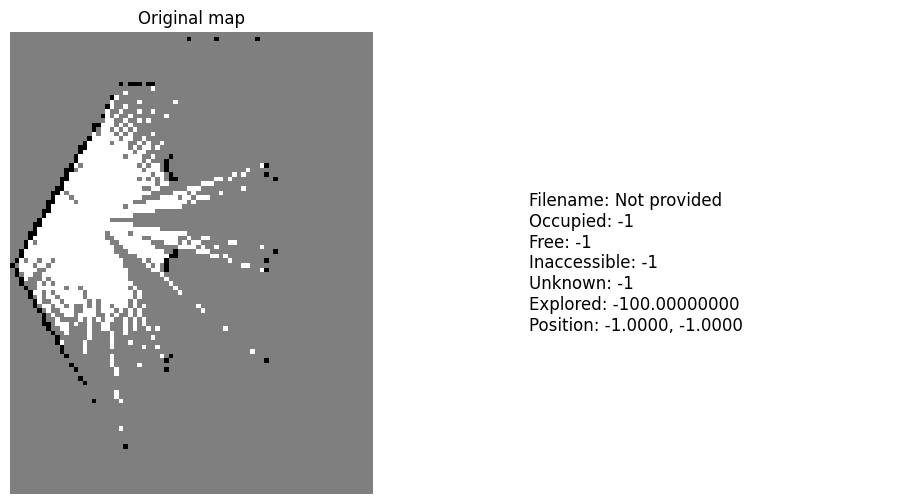

Marking position at world coordinates: (18, 41)
Marking position at world coordinates: (21, 44)
explored %f not explored %f 0.12855392156862744 0.8714460784313726


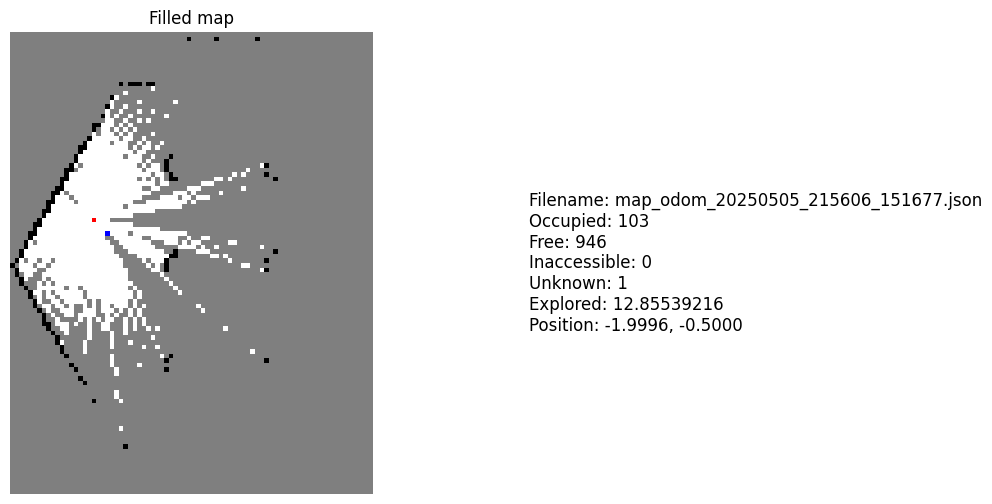

{'header': {'stamp': {'sec': 10, 'nanosec': 175000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 81, 'height': 103, 'origin': {'position': {'x': -2.9478481904103426, 'y': -2.5623769273292916, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, -1, 100, 100, 100, 100, 100, -1, 100, 100, -1, 100, -1, 100, -1, -1, 100, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 

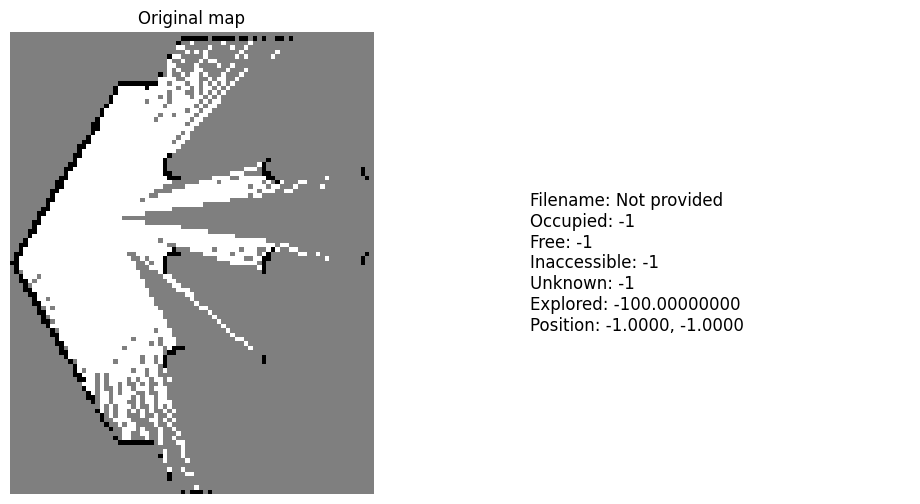

Marking position at world coordinates: (23, 38)
Marking position at world coordinates: (25, 41)
explored %f not explored %f 0.26045786887210837 0.7395421311278916


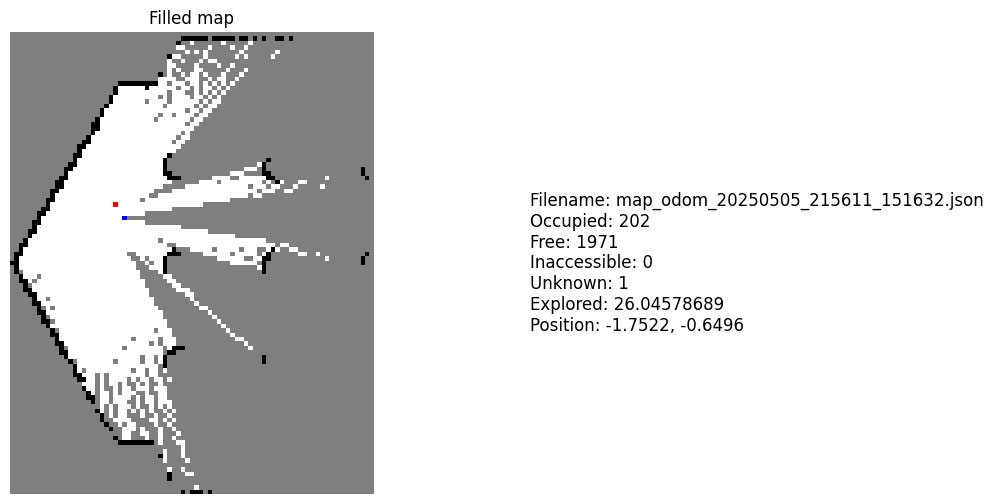

{'header': {'stamp': {'sec': 12, 'nanosec': 181000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 88, 'height': 103, 'origin': {'position': {'x': -2.9493297578515962, 'y': -2.5623769273292916, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, -1, 100, -1, 100, -1, -1, 100, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1

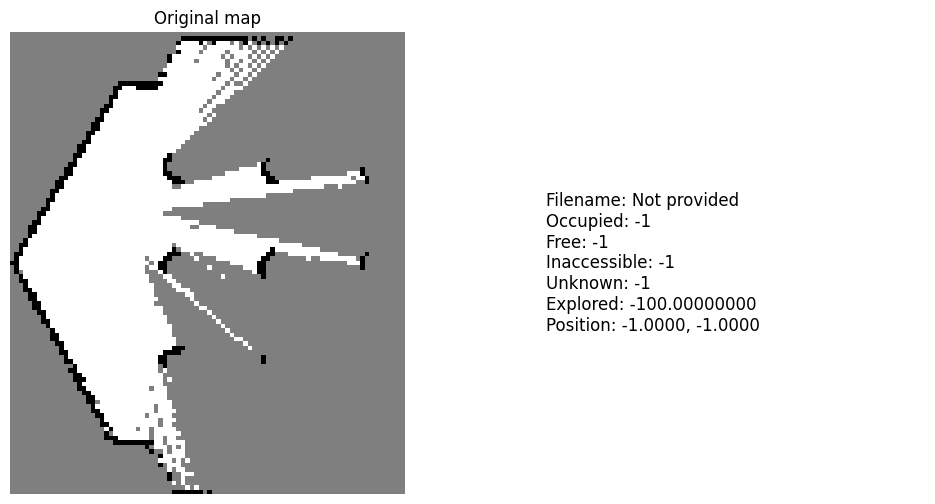

Marking position at world coordinates: (26, 29)
Marking position at world coordinates: (35, 30)
explored %f not explored %f 0.29821270962047663 0.7017872903795234


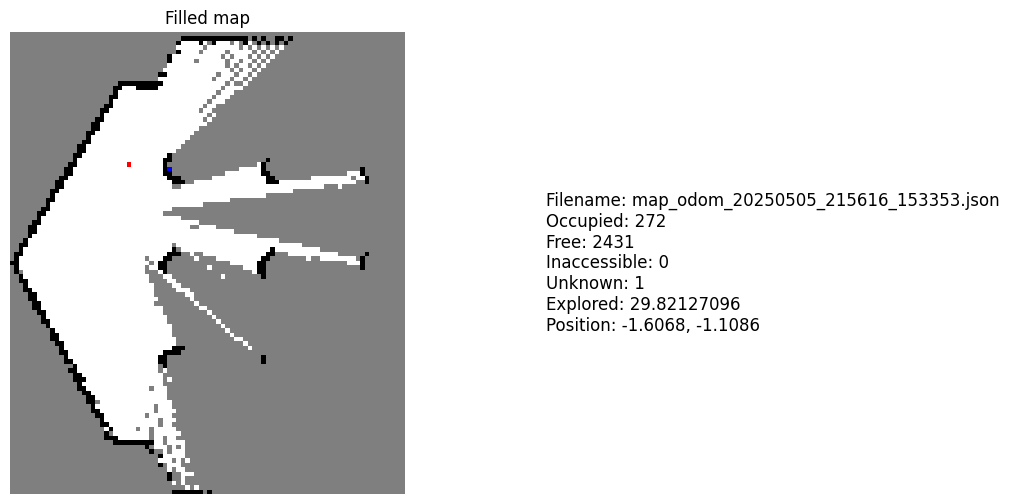

{'header': {'stamp': {'sec': 14, 'nanosec': 192000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 101, 'height': 103, 'origin': {'position': {'x': -2.9493297578515962, 'y': -2.5623769273292916, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 

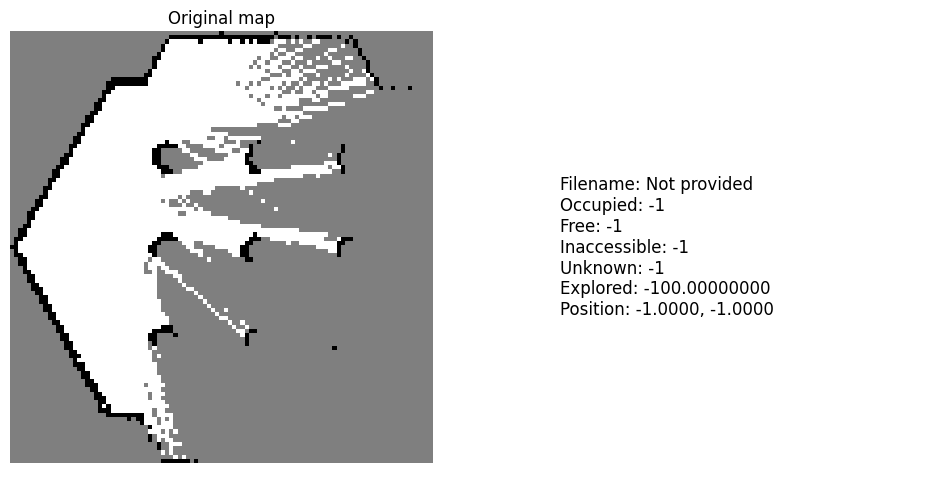

Marking position at world coordinates: (32, 20)
Marking position at world coordinates: (36, 28)
explored %f not explored %f 0.4122849178121696 0.5877150821878304


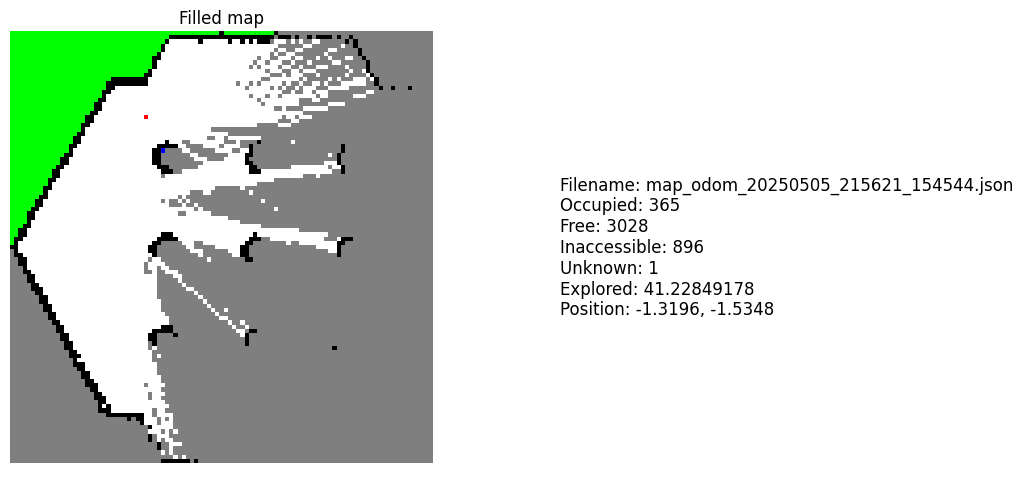

{'header': {'stamp': {'sec': 16, 'nanosec': 409000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 107, 'height': 103, 'origin': {'position': {'x': -2.9493297578515962, 'y': -2.5623769273292916, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 

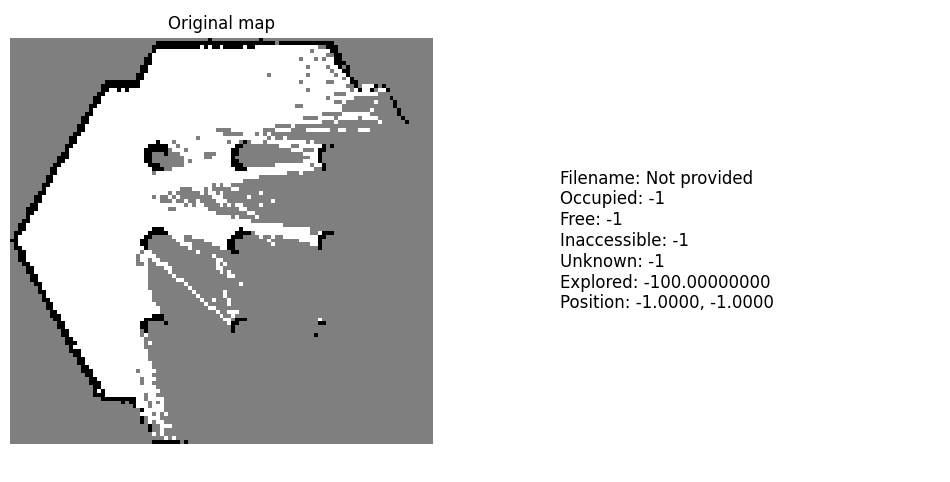

Marking position at world coordinates: (41, 14)
Marking position at world coordinates: (47, 25)
explored %f not explored %f 0.4327193539606206 0.5672806460393793


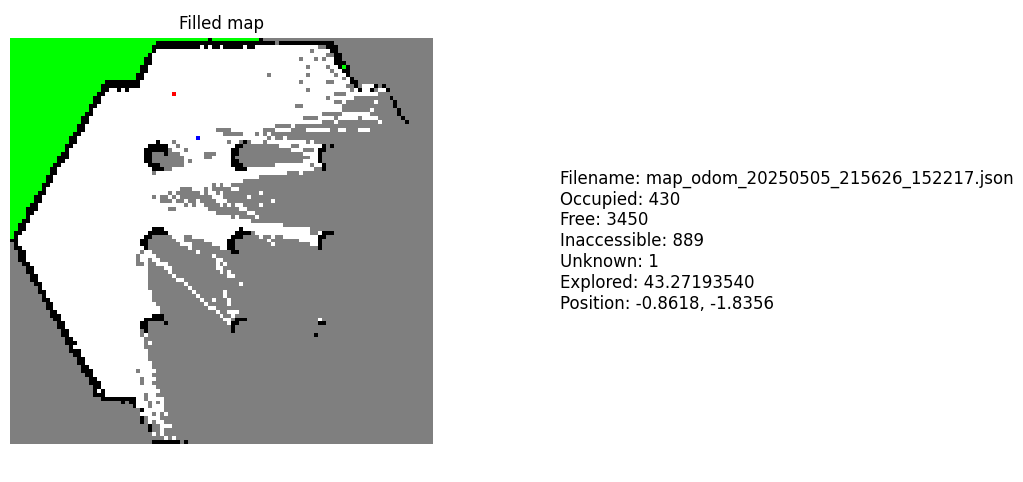

{'header': {'stamp': {'sec': 18, 'nanosec': 417000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 107, 'height': 103, 'origin': {'position': {'x': -2.9493297578515962, 'y': -2.5623769273292916, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 

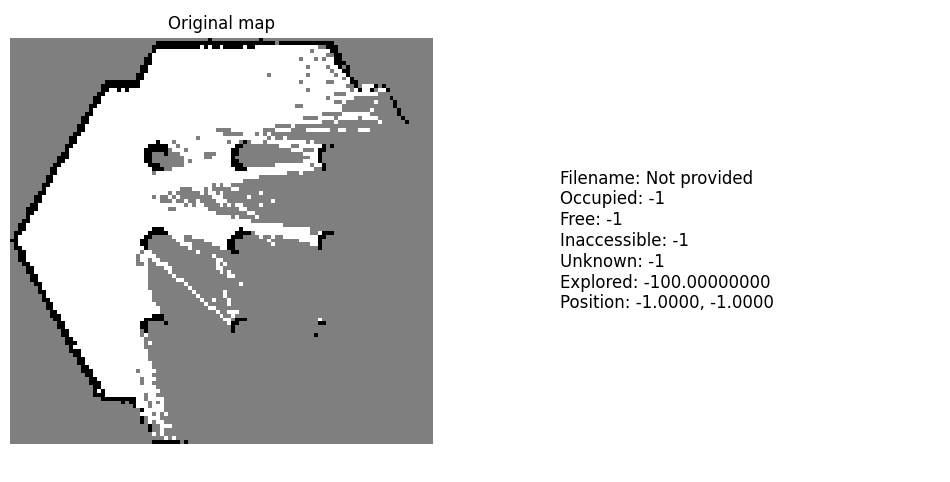

Marking position at world coordinates: (47, 10)
Marking position at world coordinates: (52, 23)
explored %f not explored %f 0.4327193539606206 0.5672806460393793


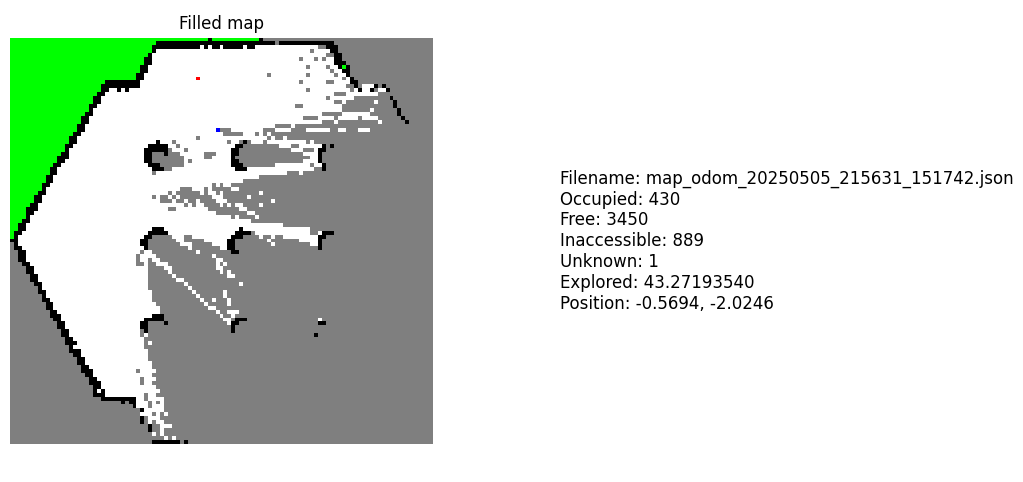

{'header': {'stamp': {'sec': 20, 'nanosec': 431000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 110, 'height': 103, 'origin': {'position': {'x': -2.9493297578515962, 'y': -2.5623769273292916, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,

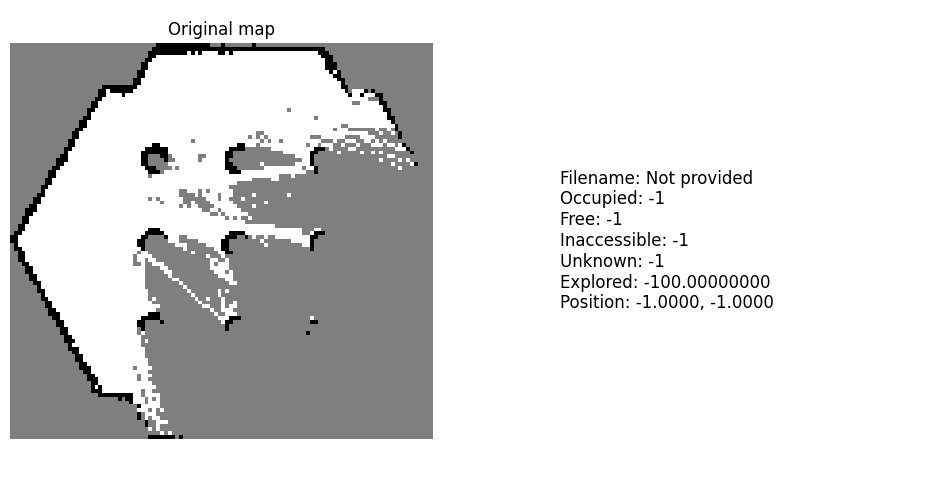

Marking position at world coordinates: (57, 12)
Marking position at world coordinates: (64, 23)
explored %f not explored %f 0.45216240070609004 0.54783759929391


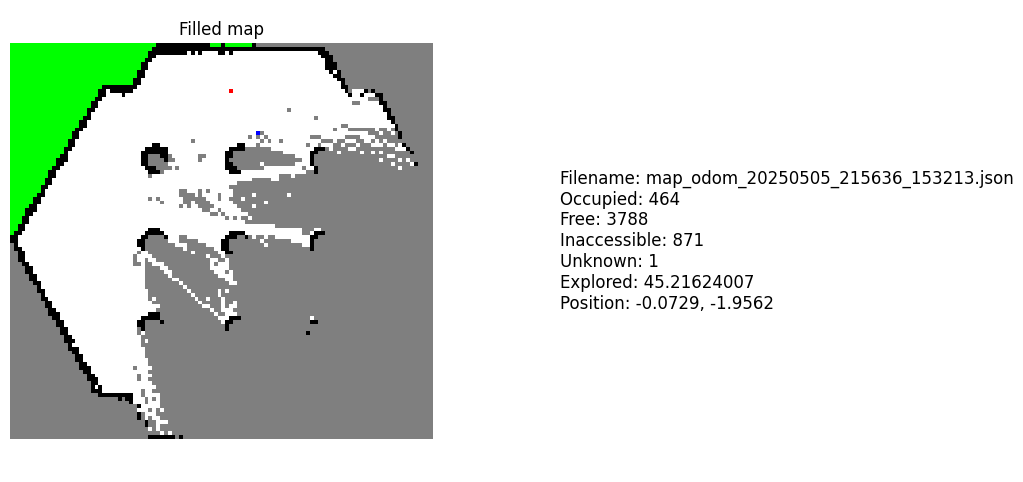

{'header': {'stamp': {'sec': 22, 'nanosec': 649000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 112, 'height': 103, 'origin': {'position': {'x': -2.9493297578515962, 'y': -2.5623769273292916, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 

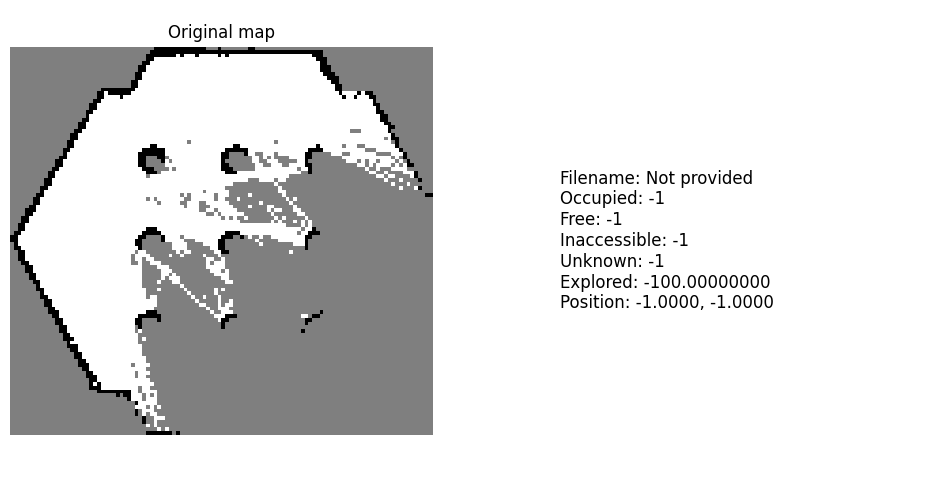

Marking position at world coordinates: (67, 13)
Marking position at world coordinates: (70, 25)
explored %f not explored %f 0.4681865464632455 0.5318134535367545


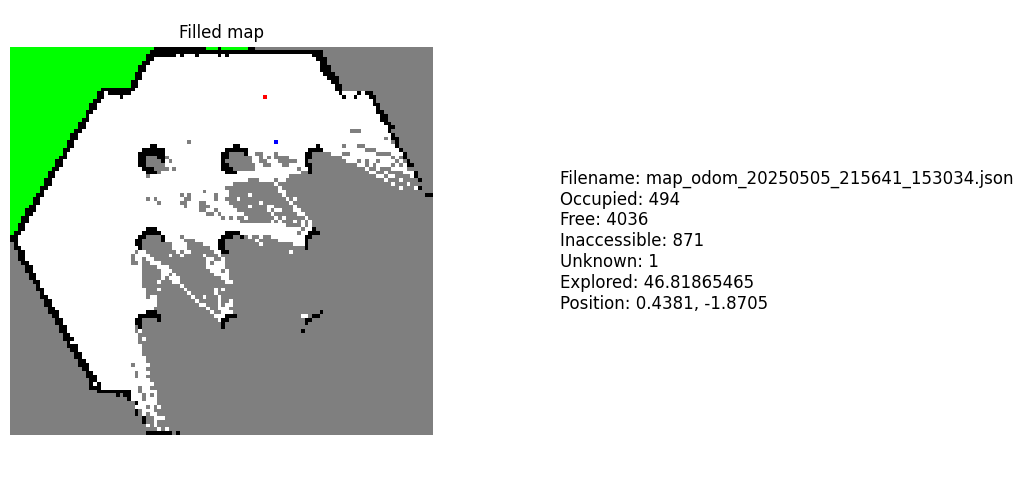

{'header': {'stamp': {'sec': 24, 'nanosec': 856000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 112, 'height': 103, 'origin': {'position': {'x': -2.9493297578515962, 'y': -2.5623769273292916, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, -1, -1, 100, 100, -1, 100, -1, -1, -1, -1, 100, 100, 100, 100, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100

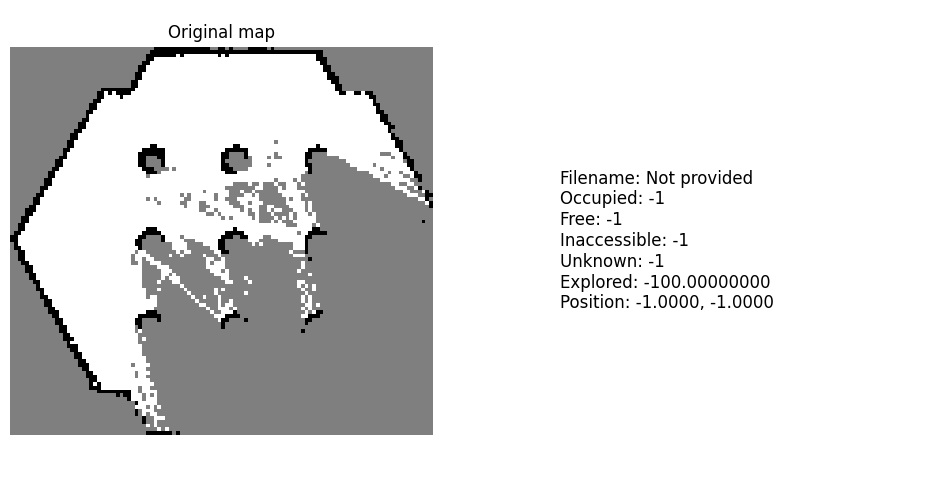

Marking position at world coordinates: (79, 16)
Marking position at world coordinates: (88, 11)
explored %f not explored %f 0.4888176144244105 0.5111823855755895


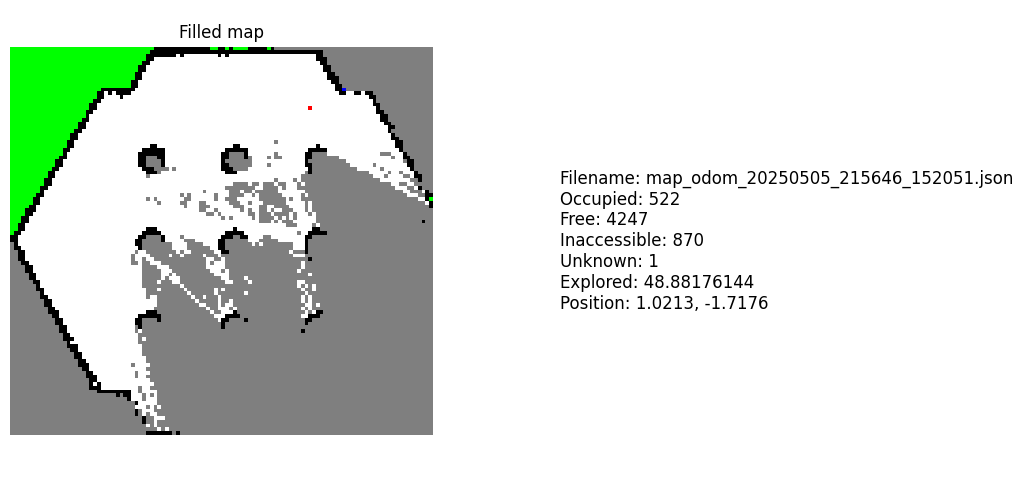

{'header': {'stamp': {'sec': 27, 'nanosec': 61000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 112, 'height': 103, 'origin': {'position': {'x': -2.9493297578515962, 'y': -2.572854641482332, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, 100, -1, 100, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,

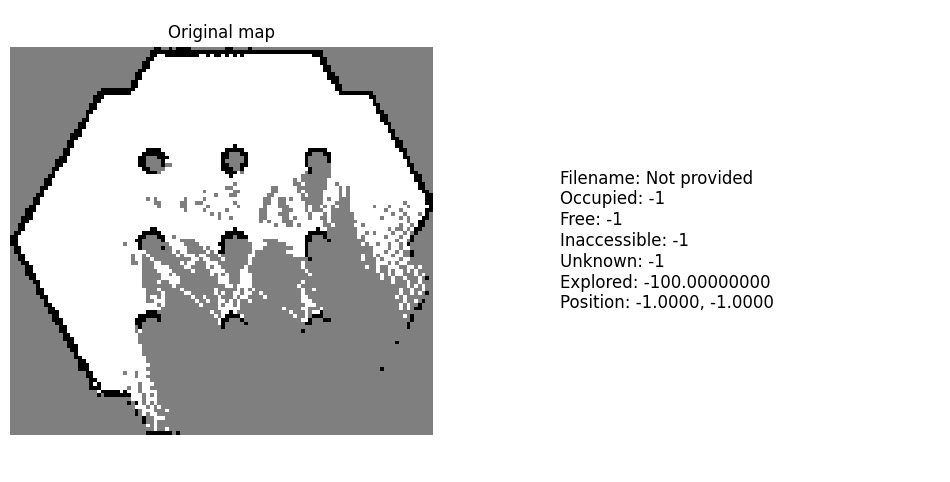

Marking position at world coordinates: (88, 23)
Marking position at world coordinates: (83, 29)
explored %f not explored %f 0.5924063800277393 0.40759361997226073


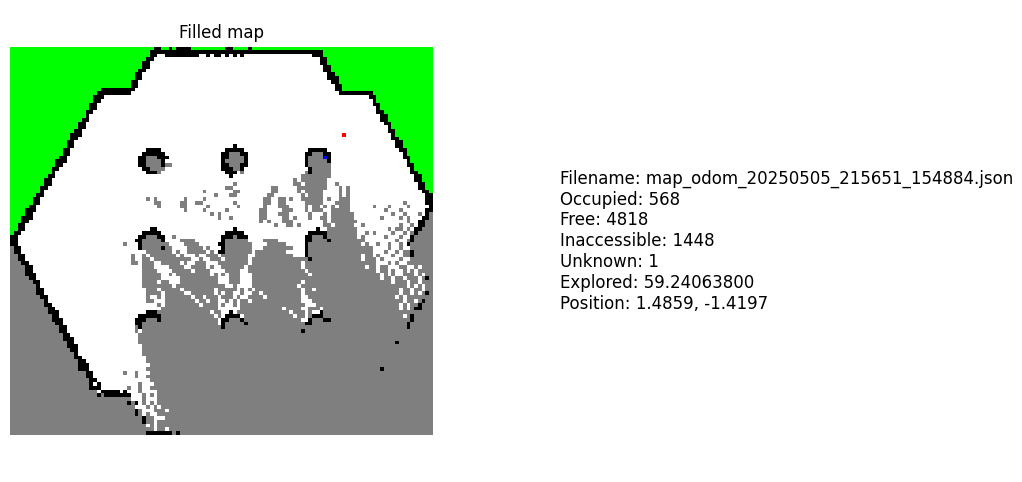

{'header': {'stamp': {'sec': 29, 'nanosec': 273000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 112, 'height': 103, 'origin': {'position': {'x': -2.9493297578515962, 'y': -2.572854641482332, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, 100, -1, 100, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, 100, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, 100, -1, -1, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100,

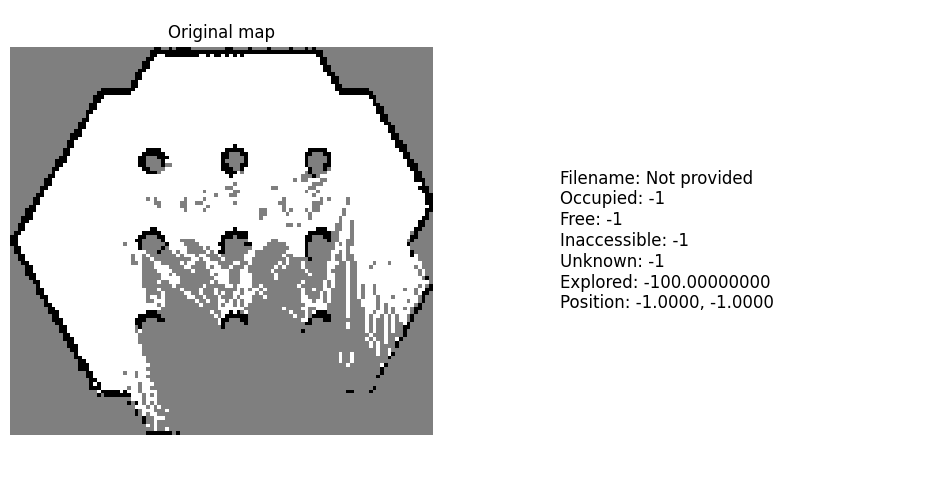

Marking position at world coordinates: (93, 32)
Marking position at world coordinates: (89, 40)
explored %f not explored %f 0.6380894590846047 0.3619105409153953


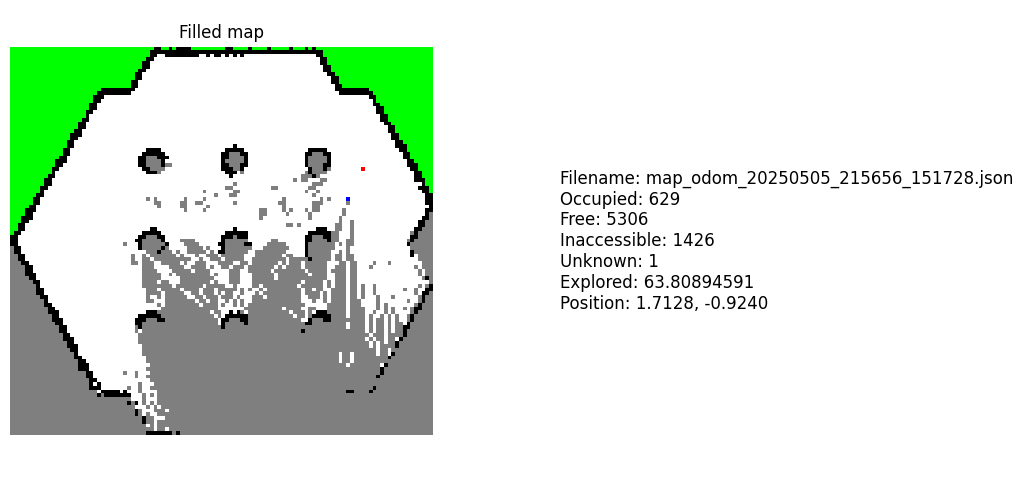

{'header': {'stamp': {'sec': 31, 'nanosec': 695000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 112, 'height': 103, 'origin': {'position': {'x': -2.9493297578515962, 'y': -2.572854641482332, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, 100, -1, 100, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, 100, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, 100, -1, -1, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100,

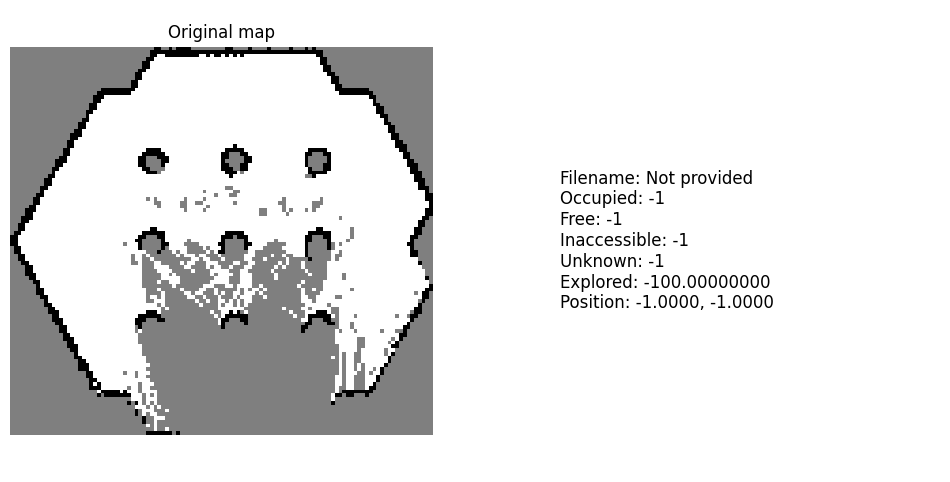

Marking position at world coordinates: (94, 44)
Marking position at world coordinates: (90, 48)
explored %f not explored %f 0.6757975034674064 0.3242024965325936


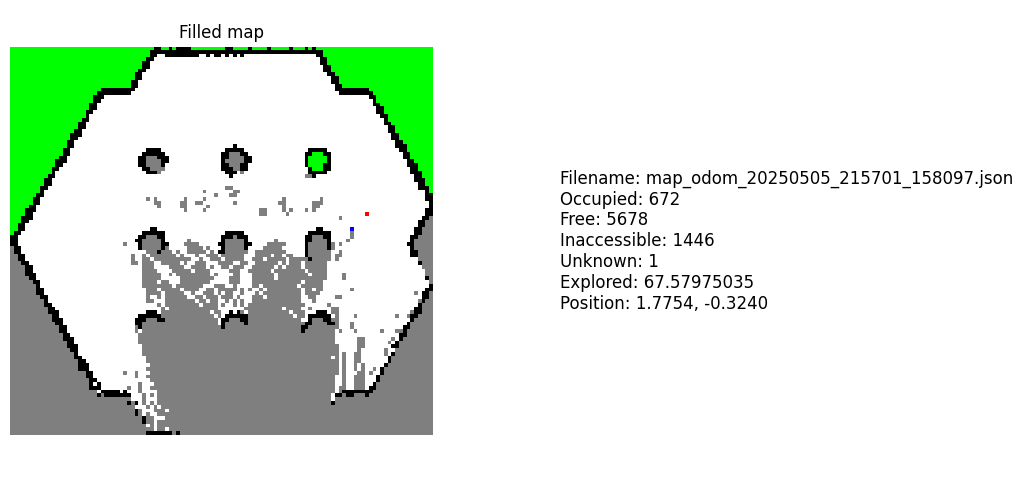

{'header': {'stamp': {'sec': 33, 'nanosec': 509000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 112, 'height': 103, 'origin': {'position': {'x': -2.9493297578515962, 'y': -2.5767466962469308, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, 100, -1, 100, 100, -1, -1, -1, -1, 100, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 

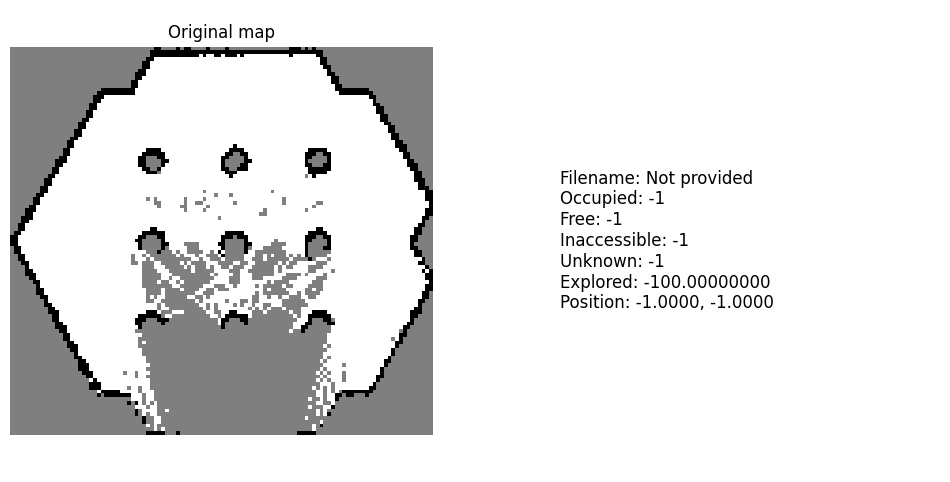

Marking position at world coordinates: (94, 53)
Marking position at world coordinates: (85, 59)
explored %f not explored %f 0.7096047156726768 0.2903952843273232


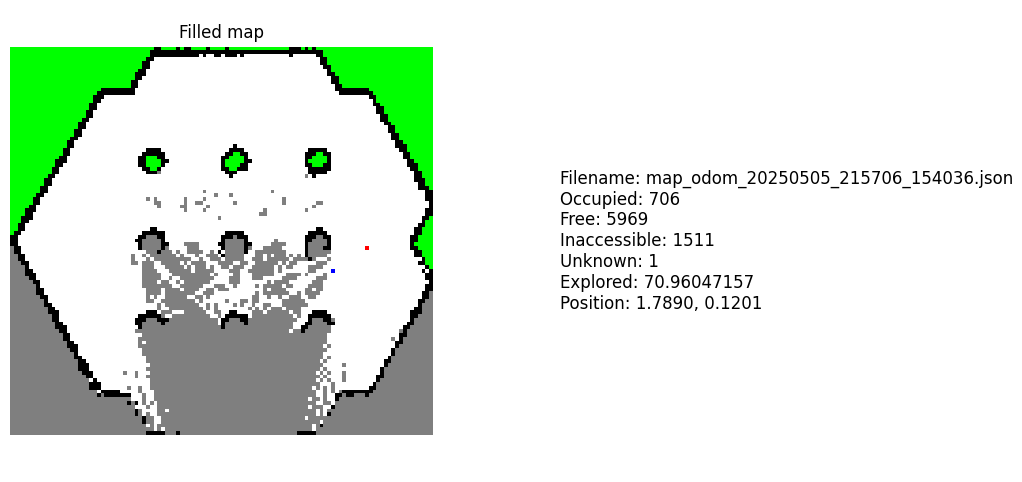

{'header': {'stamp': {'sec': 35, 'nanosec': 523000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 112, 'height': 103, 'origin': {'position': {'x': -2.9493297578515962, 'y': -2.5790035161988945, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, -1, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 1

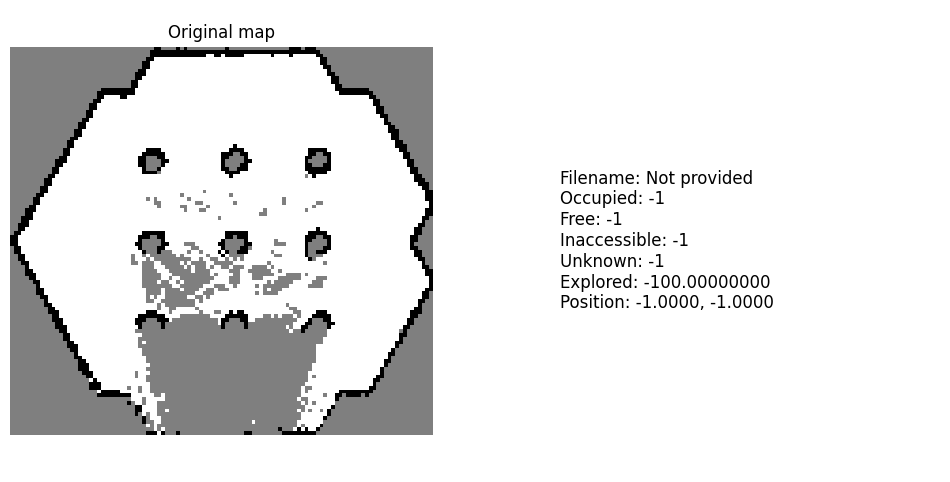

Marking position at world coordinates: (94, 64)
Marking position at world coordinates: (103, 75)
explored %f not explored %f 0.7353502080443828 0.2646497919556172


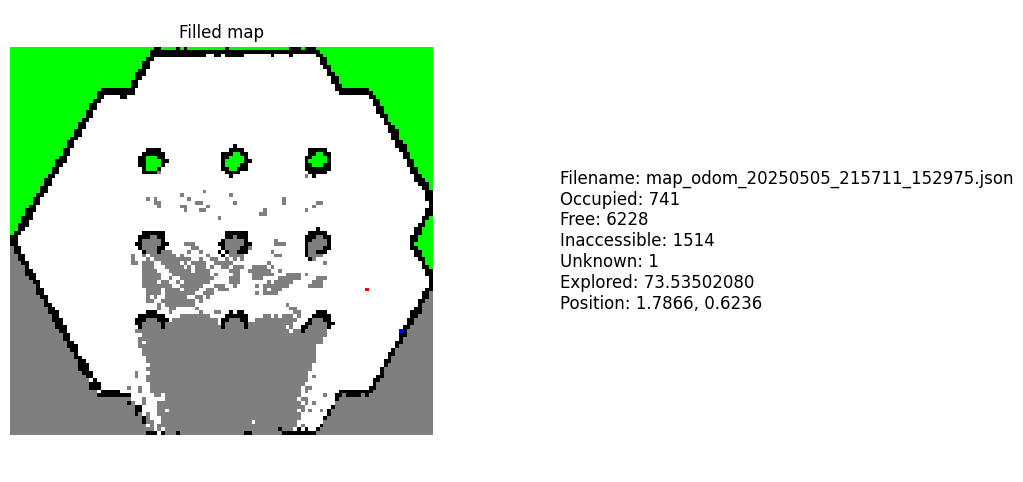

{'header': {'stamp': {'sec': 37, 'nanosec': 740000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 113, 'height': 103, 'origin': {'position': {'x': -2.9493297578515962, 'y': -2.5790035161988945, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, -1, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 10

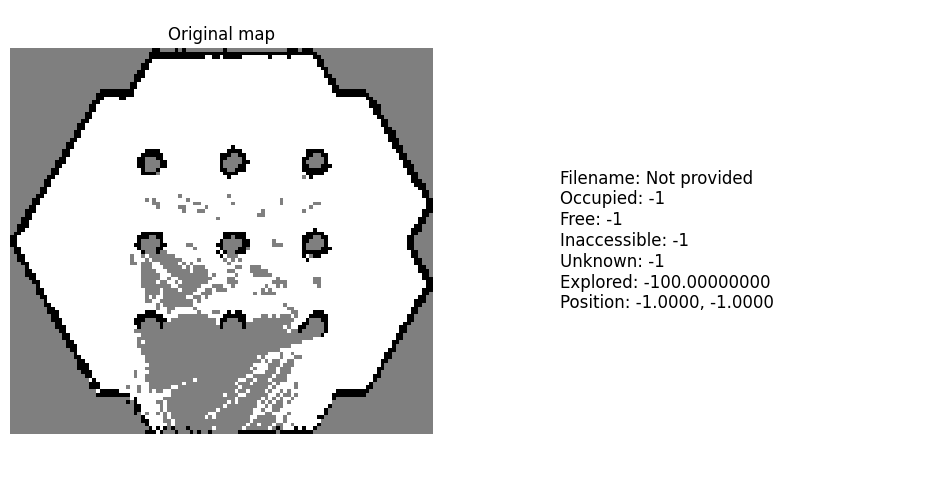

Marking position at world coordinates: (92, 74)
Marking position at world coordinates: (102, 81)
explored %f not explored %f 0.7645845863046653 0.2354154136953347


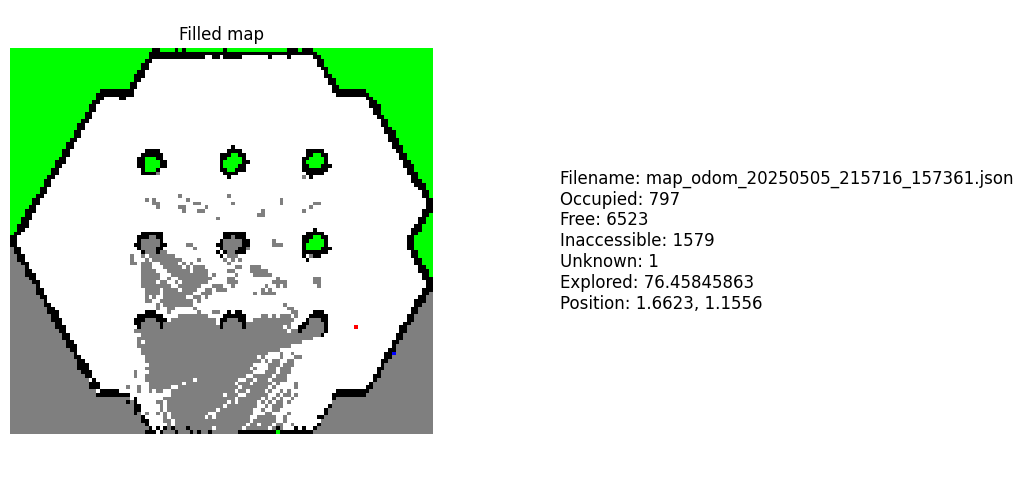

{'header': {'stamp': {'sec': 38, 'nanosec': 743000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 113, 'height': 103, 'origin': {'position': {'x': -2.9493297578515962, 'y': -2.5790035161988945, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, -1, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 10

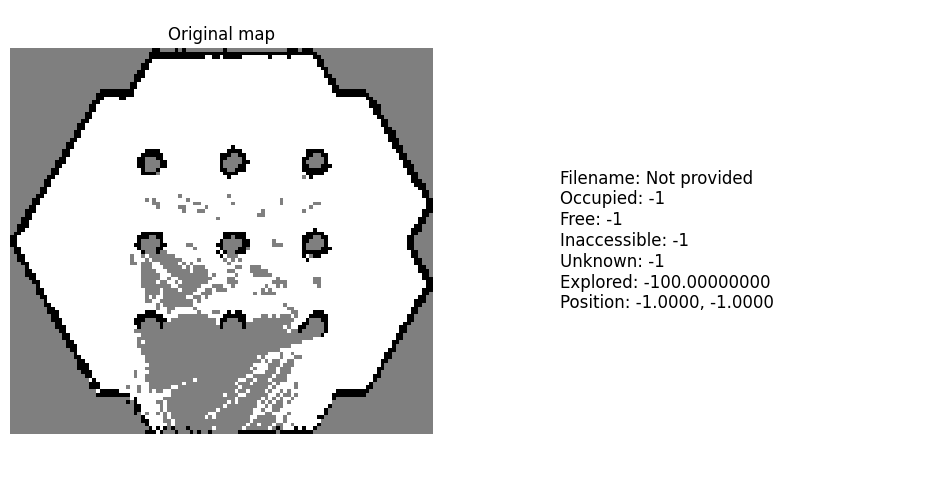

Marking position at world coordinates: (89, 78)
Marking position at world coordinates: (83, 75)
explored %f not explored %f 0.7645845863046653 0.2354154136953347


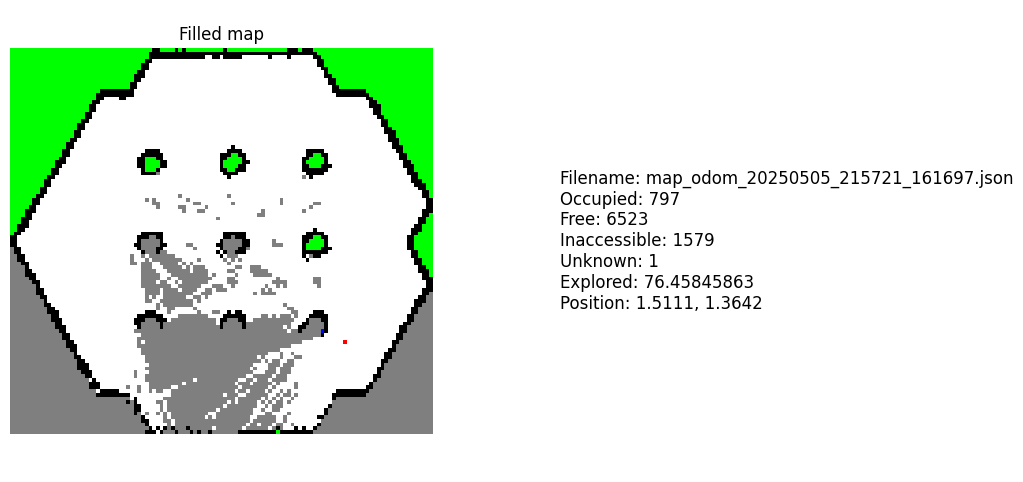

{'header': {'stamp': {'sec': 40, 'nanosec': 764000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 113, 'height': 103, 'origin': {'position': {'x': -2.9493297578515962, 'y': -2.5790035161988945, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, -1, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 10

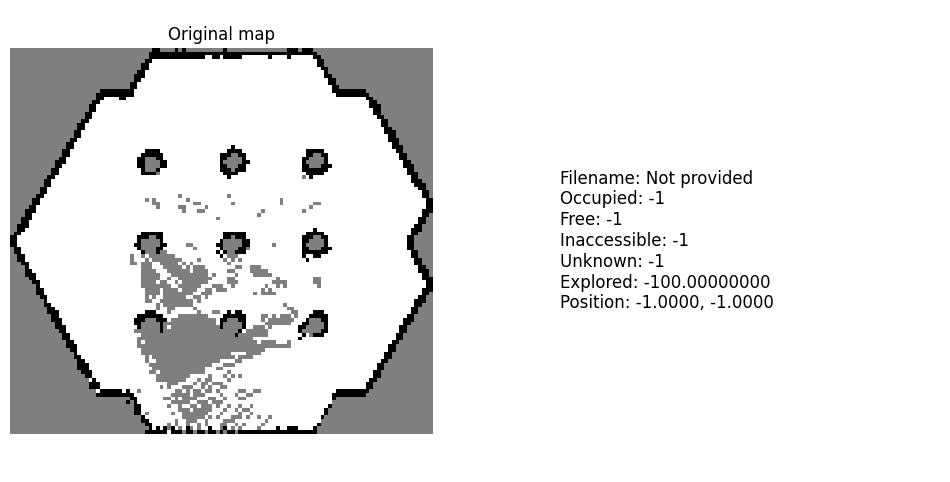

Marking position at world coordinates: (81, 83)
Marking position at world coordinates: (87, 93)
explored %f not explored %f 0.871896211014692 0.12810378898530805


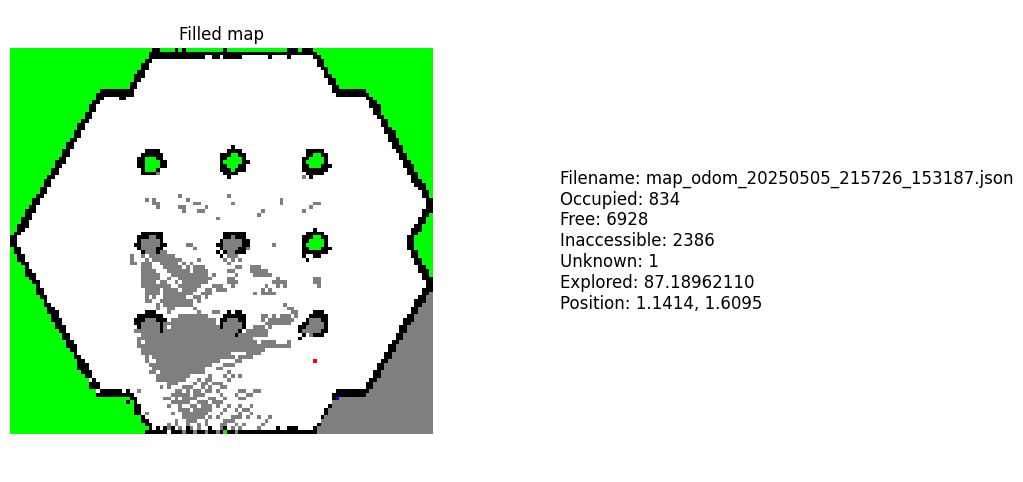

{'header': {'stamp': {'sec': 42, 'nanosec': 380000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 113, 'height': 103, 'origin': {'position': {'x': -2.9493297578515962, 'y': -2.5790035161988945, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, -1, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 10

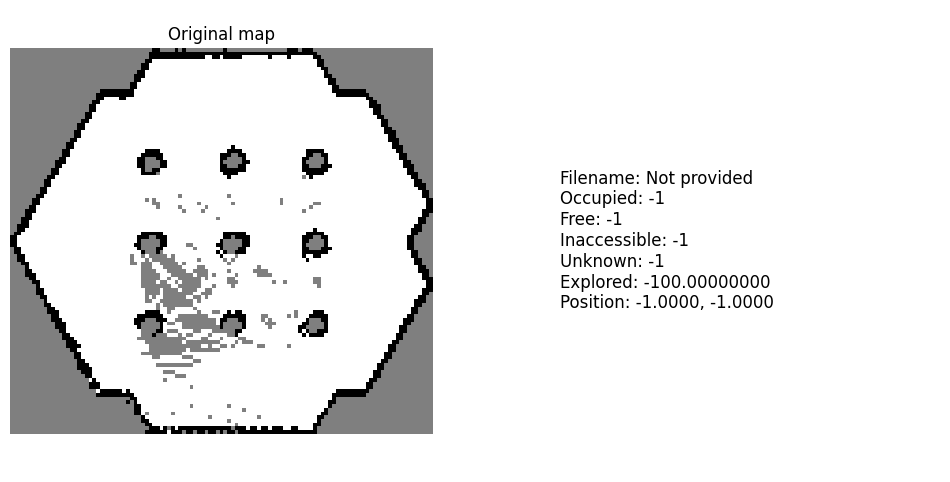

Marking position at world coordinates: (74, 87)
Marking position at world coordinates: (74, 79)
explored %f not explored %f 0.9572987370048973 0.042701262995102685


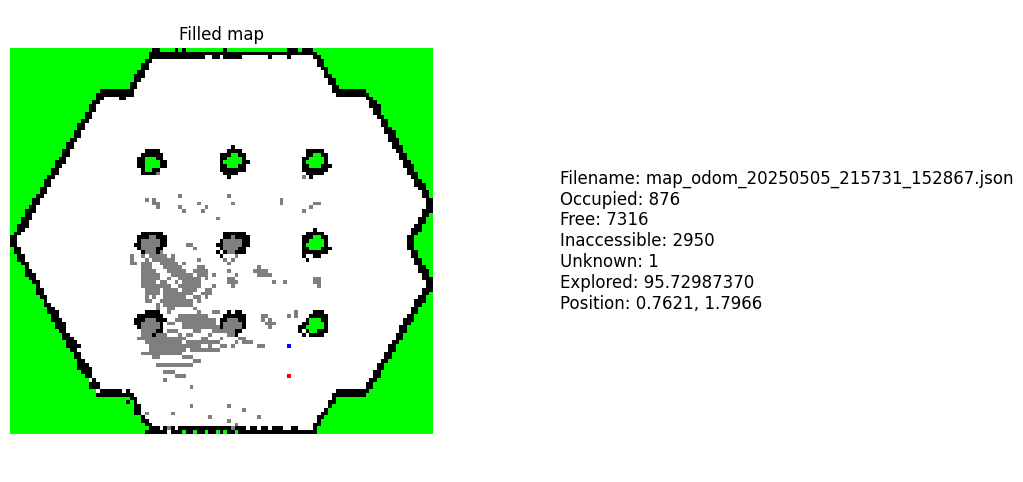

{'header': {'stamp': {'sec': 44, 'nanosec': 192000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 113, 'height': 103, 'origin': {'position': {'x': -2.9493297578515962, 'y': -2.5790035161988945, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, -1, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 10

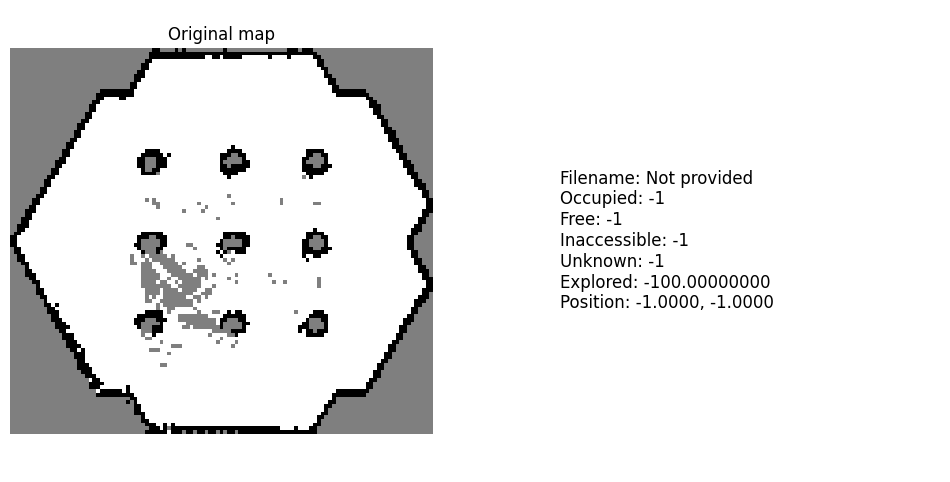

Marking position at world coordinates: (71, 88)
Marking position at world coordinates: (60, 78)
explored %f not explored %f 0.9725921470916745 0.02740785290832548


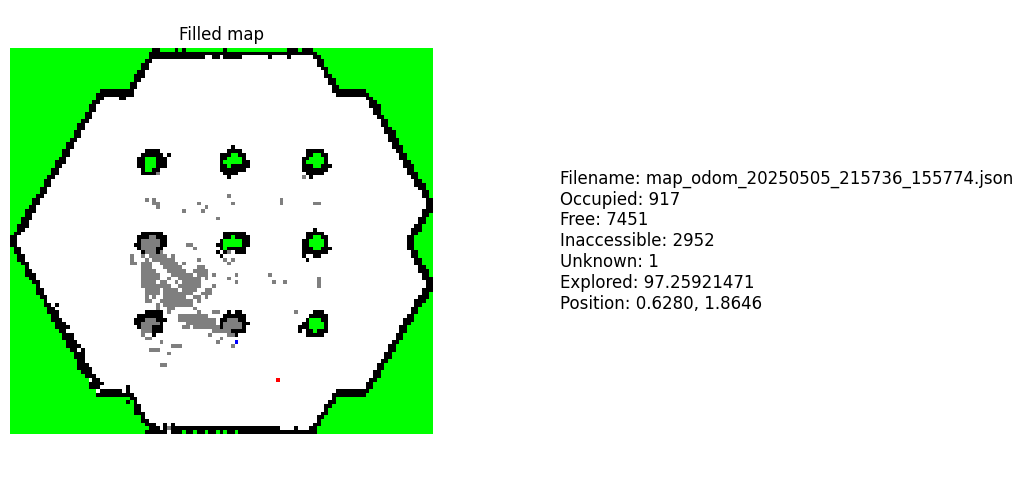

{'header': {'stamp': {'sec': 45, 'nanosec': 802000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 113, 'height': 103, 'origin': {'position': {'x': -2.9493297578515962, 'y': -2.5790035161988945, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, -1, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 10

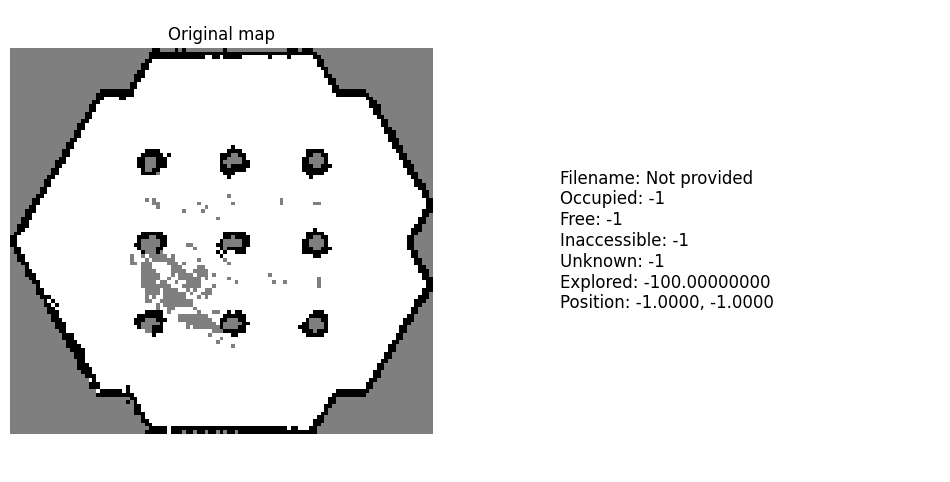

Marking position at world coordinates: (65, 91)
Marking position at world coordinates: (59, 79)
explored %f not explored %f 0.9771458029040295 0.022854197095970474


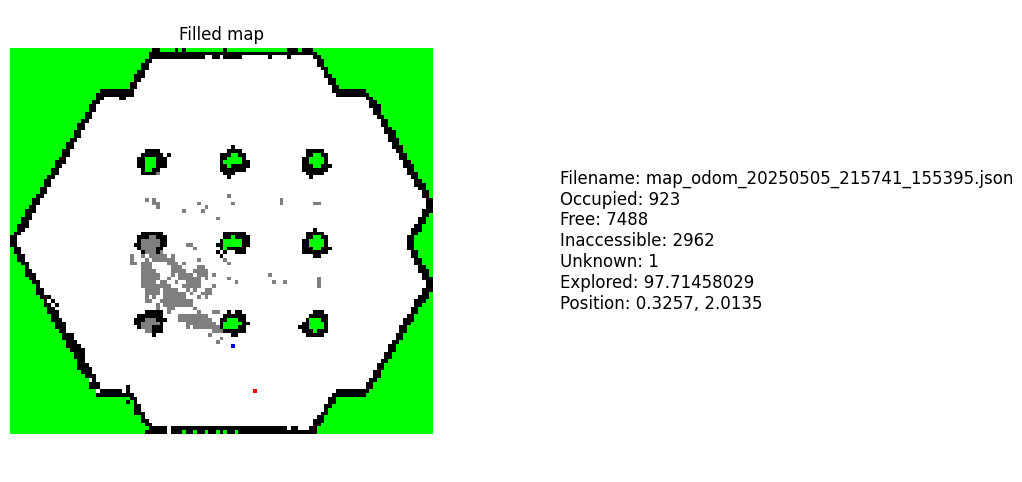

{'header': {'stamp': {'sec': 47, 'nanosec': 814000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 113, 'height': 103, 'origin': {'position': {'x': -2.9493297578515962, 'y': -2.5790035161988945, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, -1, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 10

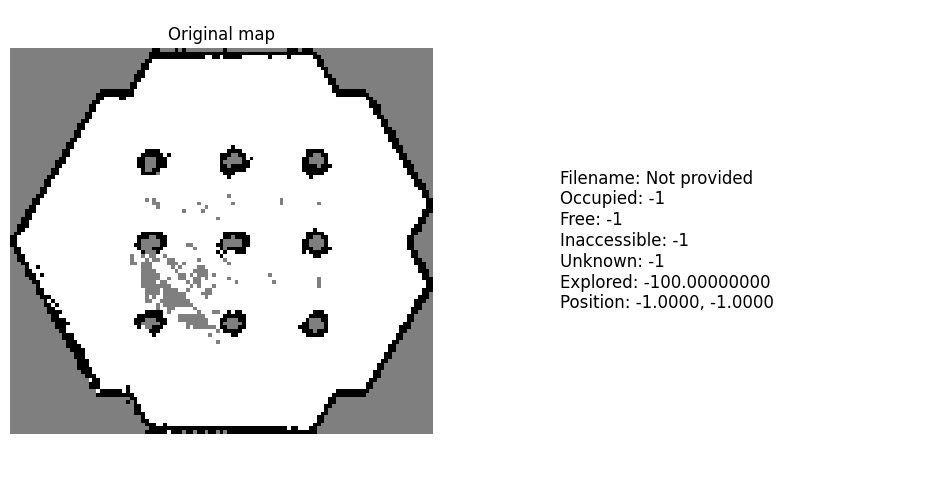

Marking position at world coordinates: (66, 92)
Marking position at world coordinates: (55, 78)
explored %f not explored %f 0.9804106882034539 0.019589311796546105


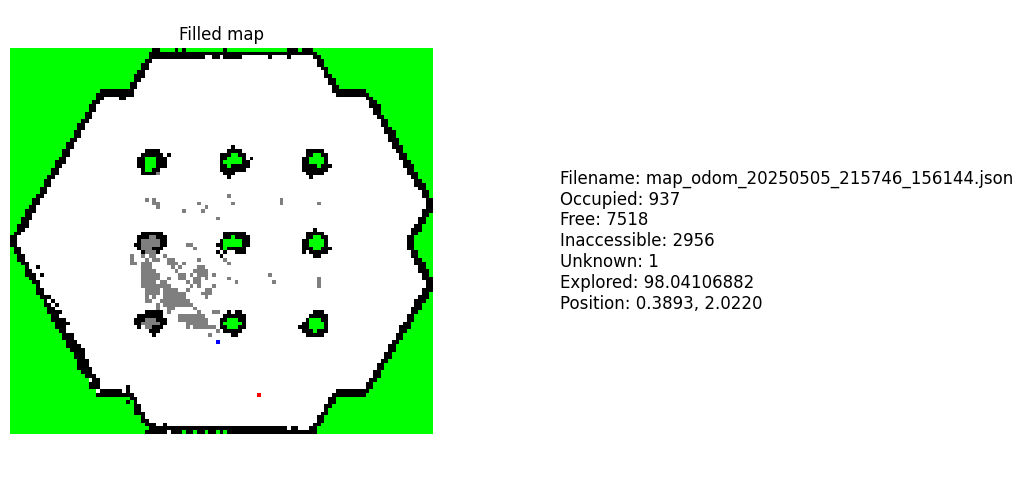

{'header': {'stamp': {'sec': 49, 'nanosec': 827000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 113, 'height': 103, 'origin': {'position': {'x': -2.9493297578515962, 'y': -2.5790035161988945, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, -1, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 10

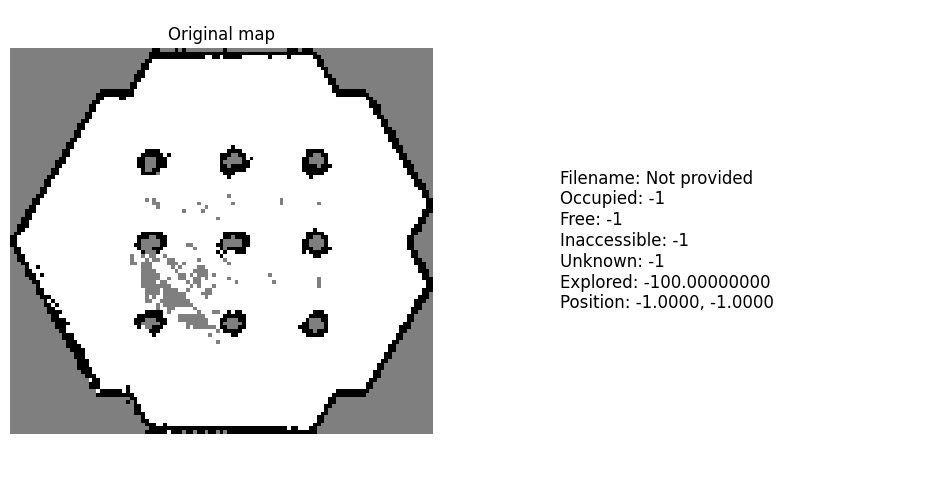

Marking position at world coordinates: (63, 91)
Marking position at world coordinates: (55, 78)
explored %f not explored %f 0.9804106882034539 0.019589311796546105


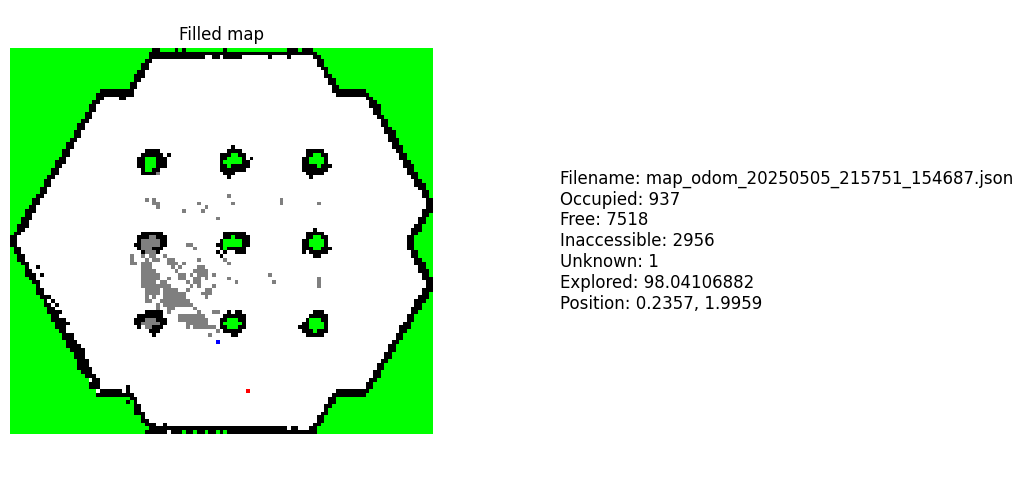

{'header': {'stamp': {'sec': 51, 'nanosec': 431000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 113, 'height': 103, 'origin': {'position': {'x': -2.9493297578515962, 'y': -2.5790035161988945, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, -1, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 10

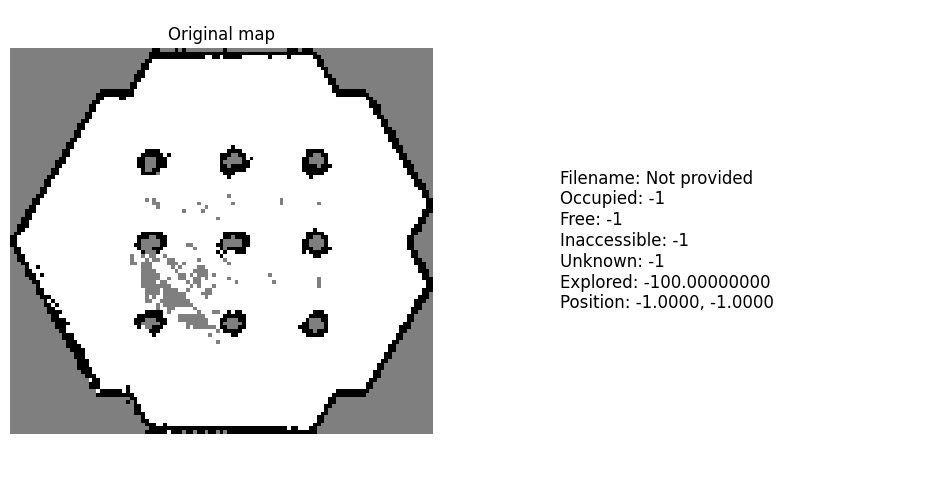

Marking position at world coordinates: (56, 89)
Marking position at world coordinates: (55, 78)
explored %f not explored %f 0.9804106882034539 0.019589311796546105


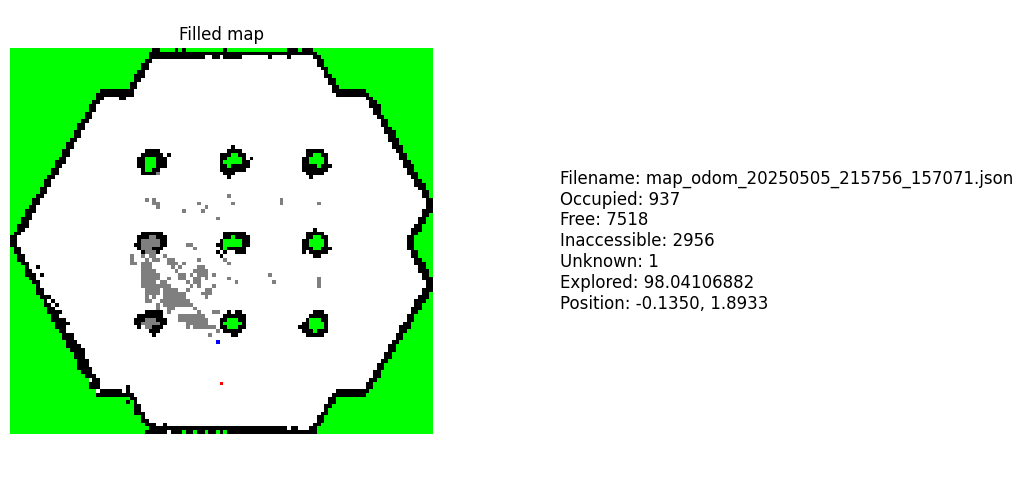

{'header': {'stamp': {'sec': 53, 'nanosec': 233000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 113, 'height': 103, 'origin': {'position': {'x': -2.9493297578515962, 'y': -2.5790035161988945, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, -1, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 10

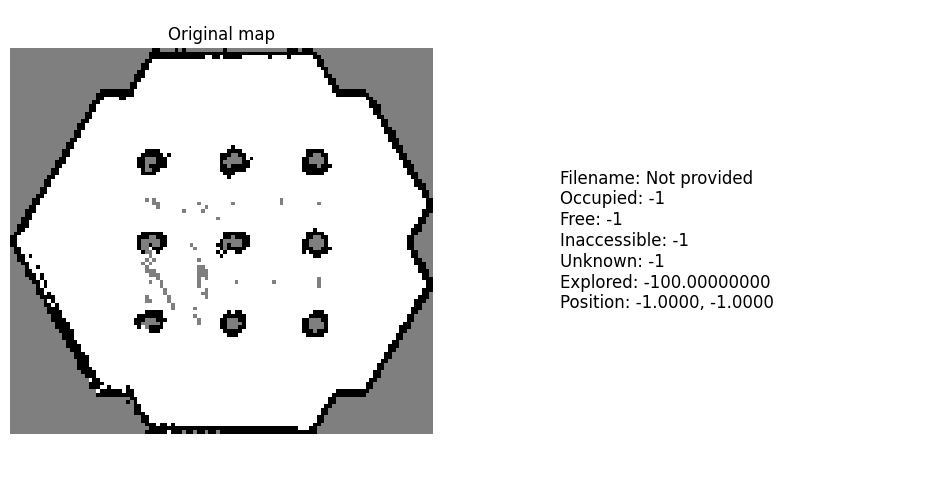

Marking position at world coordinates: (49, 84)
Marking position at world coordinates: (50, 73)
explored %f not explored %f 0.9920955408540253 0.007904459145974707


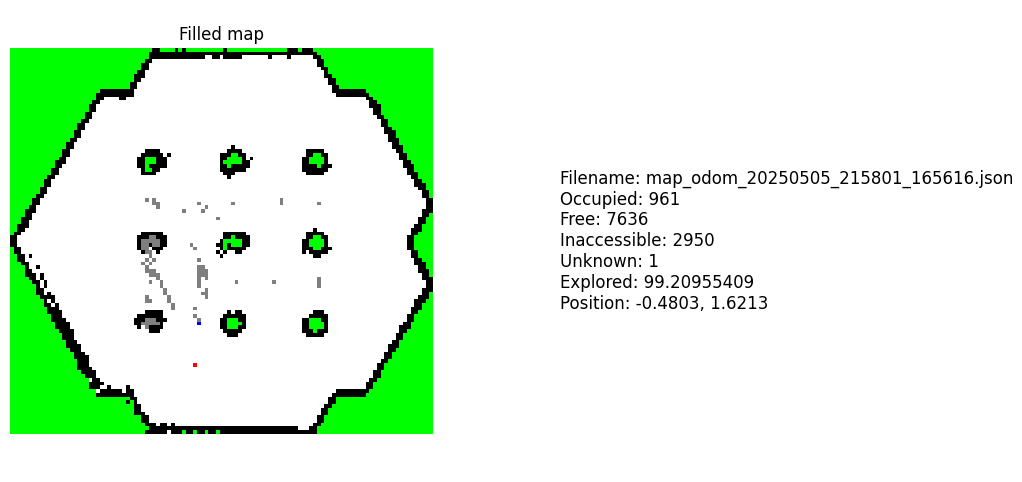

{'header': {'stamp': {'sec': 55, 'nanosec': 49000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 113, 'height': 103, 'origin': {'position': {'x': -2.9493297578515962, 'y': -2.5790035161988945, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, -1, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100

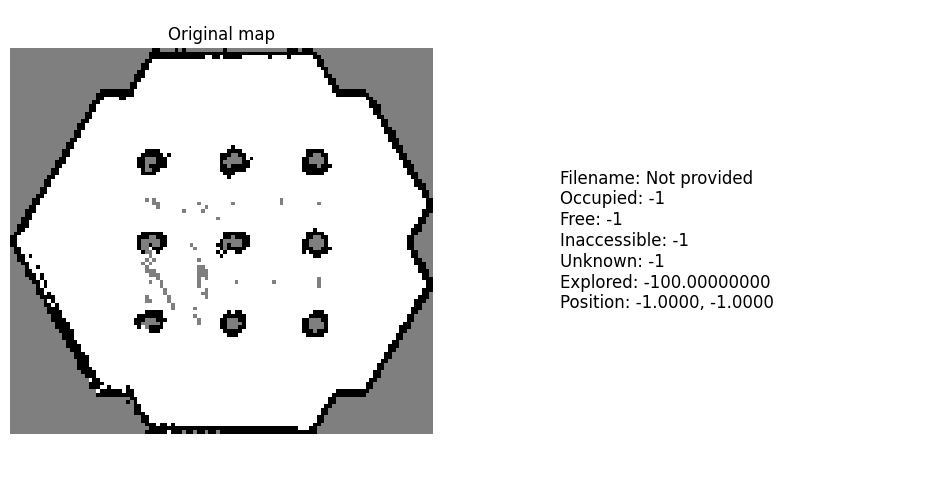

Marking position at world coordinates: (46, 74)
Marking position at world coordinates: (50, 73)
explored %f not explored %f 0.9920955408540253 0.007904459145974707


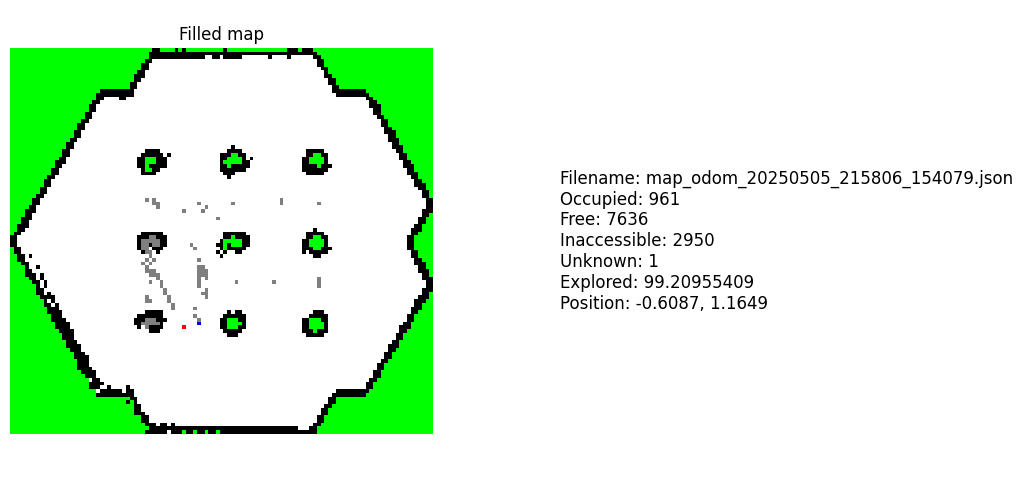

{'header': {'stamp': {'sec': 57, 'nanosec': 248000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 113, 'height': 104, 'origin': {'position': {'x': -2.9493297578515962, 'y': -2.6402825325310353, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, -1, 100, -1, -1, -1

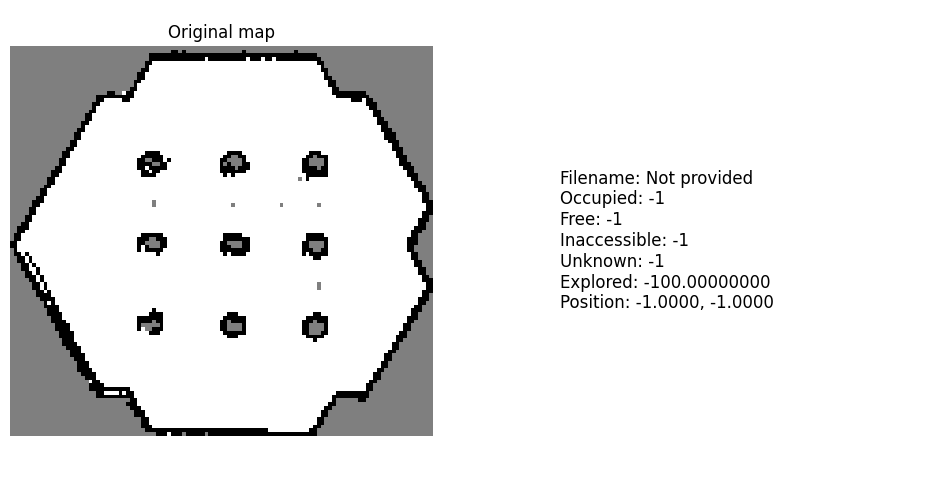

Marking position at world coordinates: (48, 66)
Marking position at world coordinates: (39, 74)
explored %f not explored %f 0.9985534377127298 0.0014465622872702477


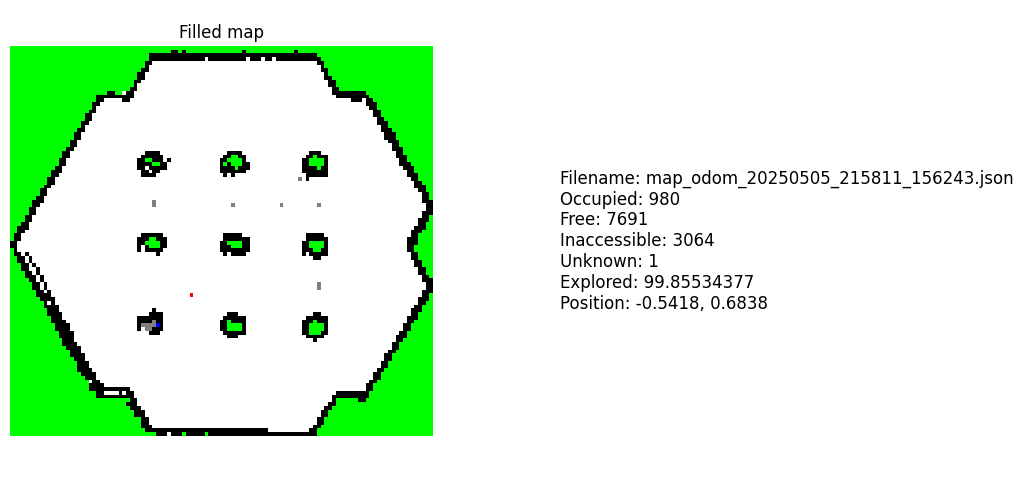

{'header': {'stamp': {'sec': 59, 'nanosec': 258000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 113, 'height': 104, 'origin': {'position': {'x': -2.9493297578515962, 'y': -2.6402825325310353, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, 100, 100, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 100, 0, 100, 100, -1, 100, -1, 10

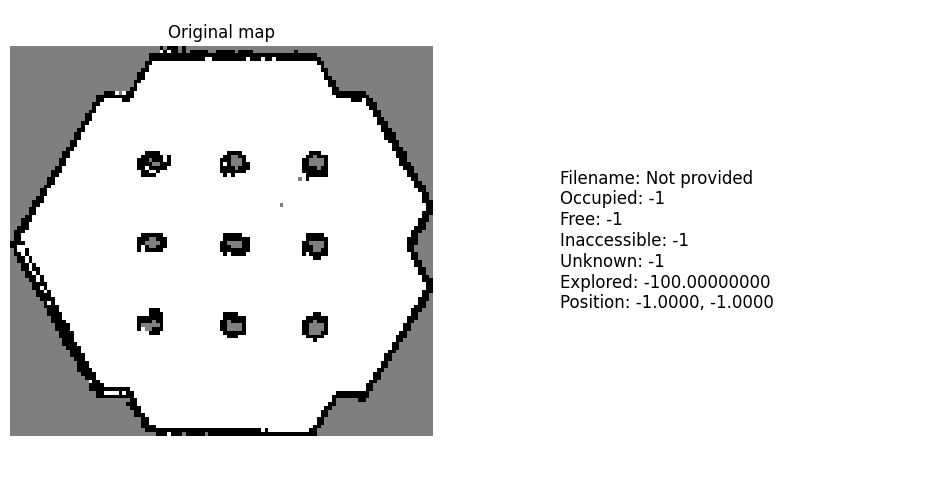

Marking position at world coordinates: (56, 62)
Marking position at world coordinates: (39, 74)
explored %f not explored %f 0.9990639891082369 0.0009360108917630949


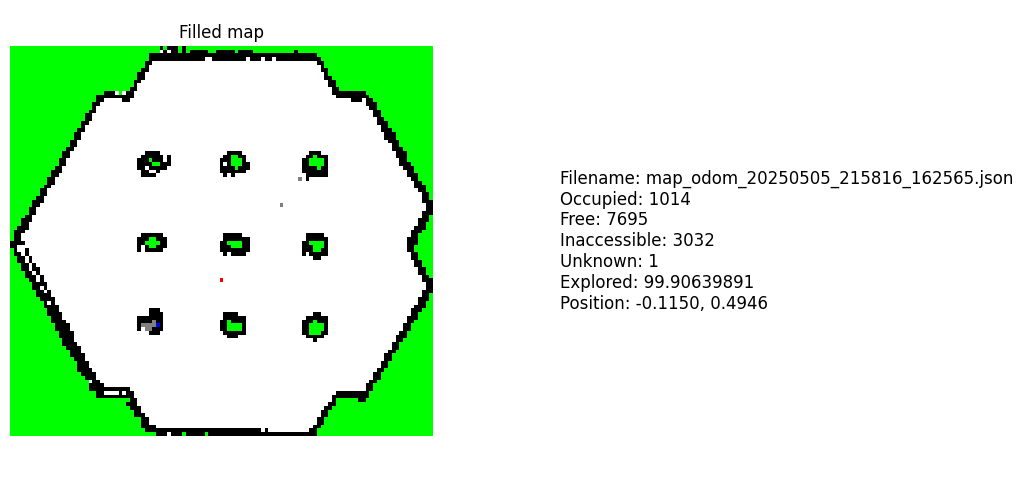

{'header': {'stamp': {'sec': 60, 'nanosec': 865000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 113, 'height': 104, 'origin': {'position': {'x': -2.9493297578515962, 'y': -2.6402825325310353, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 0, 100, 0, 100, 100, 0, 100, -1, 

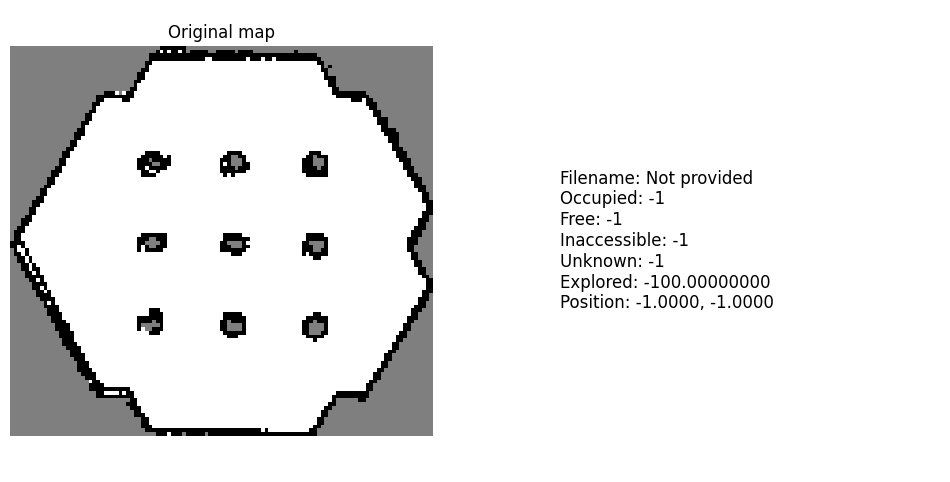

Marking position at world coordinates: (64, 59)
Marking position at world coordinates: (39, 74)
explored %f not explored %f 0.9992341729067393 0.0007658270932606737


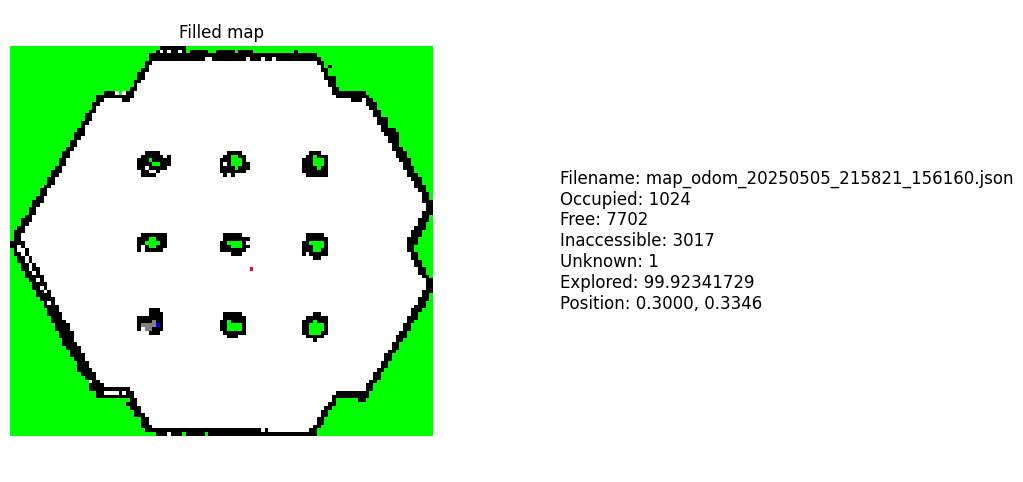

{'header': {'stamp': {'sec': 62, 'nanosec': 877000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 113, 'height': 104, 'origin': {'position': {'x': -2.9493297578515962, 'y': -2.6402825325310353, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 0, 100, 0, 100, 100, 0, 100, 100,

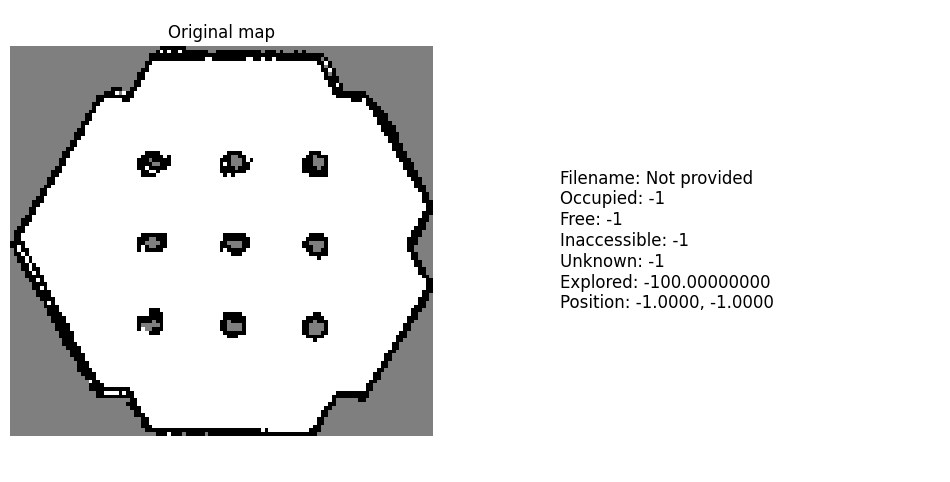

Marking position at world coordinates: (69, 51)
Marking position at world coordinates: (39, 74)
explored %f not explored %f 0.9992341729067393 0.0007658270932606737


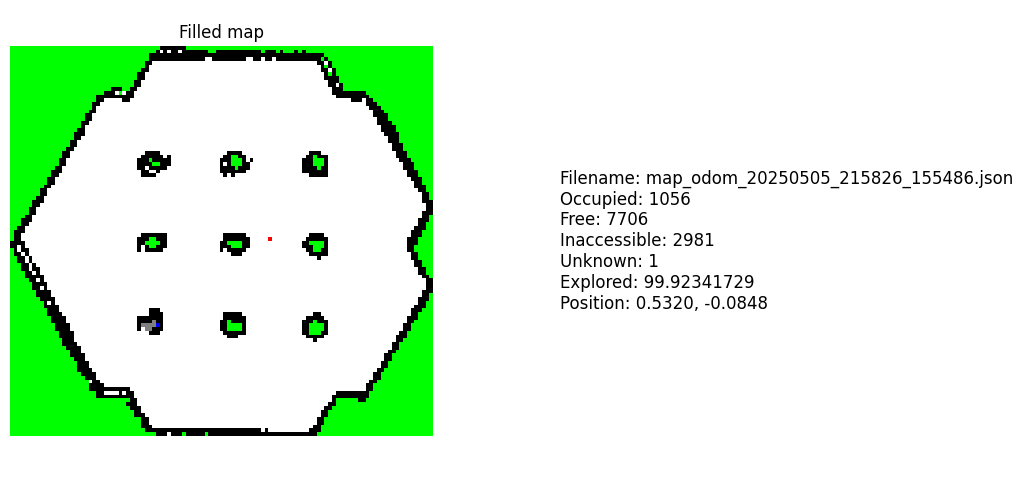

In [8]:
filenames = [_f.name for _f in os.scandir(DIRPATH) if _f.is_file()]
filenames.sort()

for _f in filenames:
    # print(_f)
    _grid, origin_x, origin_y = read_data_map(DIRPATH, _f)
    pos_x, pos_y = read_data_odom(DIRPATH, _f)
    position = get_position(pos_x, pos_y, origin_x, origin_y)

    print_plot_v2(_grid, title="Original map")
    
    filled_grid = fill_enclosed_unknowns_v2(_grid, position)
    fully_enclosed = is_fully_enclosed(filled_grid, position)
    # print(fully_enclosed, _f)
    if fully_enclosed:
        filled_grid = fill_outside_with_val_inaccessible(filled_grid, position)
    
    # filled_grid = mark_position(filled_grid, pos_x, pos_y, origin_x, origin_y)
    
    filled_grid = mark_position_v2(filled_grid, position[0], position[1], VAL_CURR_POSITION)
    _,_, goal_x, goal_y = explore_nearest_unknown(filled_grid, position[0], position[1], origin_x, origin_y)
    if goal_x is not None and goal_y is not None:
        filled_grid = mark_position_v2(filled_grid, goal_x, goal_y, VAL_NEXT_GOAL)
    else:
        print("No unknowns found")
    
    occupied,\
    free,\
    inaccessible,\
    unknown,\
    explored_percent = calculate_remaining_space(filled_grid)
    print_plot_v2(
        filled_grid,
        title=f"Filled map",
        filename=_f,
        occupied=occupied,
        free=free,
        inaccessible=inaccessible,
        unknown=unknown,
        explored_percent=explored_percent,
        position_x=pos_x,
        position_y=pos_y
    )
    
    # break
    
    # TODO create fucntion to fill outer space / not calculate the remaining outer space